# Examining Model Rank

In this notebook, we internally compare Prism ranks, and how rank changes to (i) our choice of rank metric, (ii) our choice of tie threshold, and (iii) group inclusion in the scoring process.


Note it takes quite a long time to run with a large number of bootstraps!

In [1]:
# Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from matplotlib.ticker import MultipleLocator, FixedLocator
from tqdm import tqdm
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import load_data, unnest_columns, pivot_to_wide_format
from src.viz.plot_config import *
from src.data_analysis.ranking import *


# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)


# Set data path
PROJECT_ROOT = find_project_root()
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/model_rank_plots"
ensure_dir_exists(PLOT_PATH)


# Load data
data_dict = load_data(PROJECT_ROOT, metadata=False)

# Unnest survey
survey = data_dict["survey"]
survey = unnest_columns(survey, ["ethnicity", "religion", "location"])

In [2]:
SHOW_PLOTS = True
BOOTSTRAP_ITER = 1000

### Model Names

In [3]:
model_name_table = pd.read_csv(
    f"{PROJECT_ROOT}/data/storage/mappings/model_mapping.csv"
)
# Turn into dictionary
model_name_mapping = dict(
    zip(model_name_table["long_name"], model_name_table["short_name"])
)
data_dict["utterances"]["model_name"] = data_dict["utterances"]["model_name"].map(
    lambda x: model_name_mapping[x] if x in model_name_mapping else x
)

model_code_mapping = dict(
    zip(model_name_table["short_name"], model_name_table["longcode"])
)

### Data Prep

In [4]:
# Get normalised scores
utterances = data_dict["utterances"]
utterances = get_additional_utterance_metrics(utterances)
# Update dict
data_dict["utterances"] = utterances

In [5]:
# Pivot to wide format
interactions = pivot_to_wide_format(data_dict["utterances"])
data_dict["interactions"] = interactions

## Shared Functions

In [6]:
def score2rank_multimetric(score_df):
    rank_dictionaries = []
    columns = []

    for c in score_df.columns:
        # Get rank
        if c in ["mean_within_turn_rank", "rank_centrality_score"]:
            ascending = False
        else:
            ascending = True
        score_df["rank"] = score_df[c].rank(ascending=ascending)
        # Store as dictionary
        model_dict = score_df.set_index(score_df.index)["rank"].to_dict()
        rank_dictionaries.append(model_dict)
        columns.append(c)
        score_df.drop("rank", inplace=True, axis=1)

    # Turn into dataframe
    combined_rank_df = pd.DataFrame.from_records(rank_dictionaries).T
    combined_rank_df.columns = columns

In [7]:
def score2rank(score_df, multimetric=False, metric_name="rank_centrality_score"):
    rank_dictionaries = []
    columns = []

    for c in score_df.columns:
        # Get rank
        if multimetric:
            toggle = c
        else:
            toggle = metric_name
        if toggle in ["mean_within_turn_rank"]:
            ascending = True
        else:
            ascending = False
        score_df["rank"] = score_df[c].rank(ascending=ascending)
        # Store as dictionary
        model_dict = score_df.set_index(score_df.index)["rank"].to_dict()
        rank_dictionaries.append(model_dict)
        columns.append(c)
        score_df.drop("rank", inplace=True, axis=1)

    # Turn into dataframe
    combined_rank_df = pd.DataFrame.from_records(rank_dictionaries).T
    combined_rank_df.columns = columns

    return combined_rank_df

#### Parallel Plot for Observing Rank Diffs

In [8]:
def parallel_plot_from_rank_df(
    combined_rank_df,
    figsize=(10, 7),
    palette="roma",
    label_markers=False,
    save_name=None,
):
    # Create parallel coordinates plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    columns = combined_rank_df.columns

    # Set up colors
    colors = get_equally_spaced_colors(palettes_dict[palette], len(combined_rank_df))
    if palette in ["hawaii"]:
        # Reverse
        colors = colors[::-1]

    # Sort by rank
    combined_rank_df = combined_rank_df.sort_values(by=columns[0])

    # Plot lines first
    # Adding vertical lines at each x-tick and column names
    for x, col_name in enumerate(combined_rank_df.columns):
        ax.axvline(x=x, color="grey", linestyle="--", lw=3)

    # Drawing lines
    for i, (idx, row) in enumerate(combined_rank_df.iterrows()):
        y = row[[col for col in columns]].astype(float).values
        x = np.arange(len(columns))
        ax.plot(x, y, color=colors[i], marker="o", linewidth=4)
        # Marker labels
        if label_markers:
            for xi, yi in zip(x[1:], y[1:]):

                # Dummy box for white box (so we can reduce opacity)
                ax.text(
                    xi,
                    yi + 0.01,
                    f"{model_code_mapping[idx]}",
                    ha="center",
                    va="center",
                    fontsize=14,
                    zorder=101,
                    color="white",
                    fontweight="semibold",
                    bbox=dict(
                        facecolor="white",
                        alpha=1,
                        edgecolor=colors[i],
                        linewidth=3,
                        boxstyle="round,pad=0.2",
                    ),
                )

                # Add model code (short name so we can track positions of each model)
                text_color = "white" if is_dark_color(colors[i]) else "black"
                ax.text(
                    xi,
                    yi + 0.01,
                    f"{model_code_mapping[idx]}",
                    ha="center",
                    va="center",
                    fontsize=14,
                    zorder=101,
                    color="black",
                    # Fancy box
                    bbox=dict(
                        facecolor=colors[i],
                        alpha=0.6,
                        linewidth=0,
                        edgecolor=colors[i],
                        boxstyle="round,pad=0.2",
                    ),
                )

            # Label on the axis
            ax.text(
                -0.08,
                y[0],
                f"{idx} ({model_code_mapping[idx]})  ",
                ha="right",
                va="center",
                fontsize=14,
                color="black",
            )

        else:
            ax.text(
                -0.04,
                y[0],
                f"  {idx}   ",
                ha="right",
                va="center",
                fontsize=14,
            )

        # Dummy circle for reduced alpha
        ax.plot(
            0,
            y[0],
            "o",
            ms=20,
            color="white",
            markeredgecolor=colors[i],
            markeredgewidth=3,
            zorder=99,
            alpha=1,
        )

        # Actual circle
        ax.plot(
            0,
            y[0],
            "o",
            ms=20,
            color=colors[i],
            markeredgecolor="white",
            markeredgewidth=0,
            zorder=100,
            alpha=0.8,
        )

        # Add the marker text
        ax.text(
            0,
            y[0] - 0.0,
            i + 1,
            ha="center",
            va="center",
            fontsize=14,
            color="black",
            fontweight="bold",
            zorder=101,
        )

    # Inverse y-axis
    plt.gca().invert_yaxis()

    # Setting the x-axis labels and limits
    plt.xticks(
        ticks=np.arange(len(columns)),
        labels=columns,
        rotation=45,
    )

    plt.xticks(rotation=90)

    # Removing axis borders and y-axis labels
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.yticks([])

    plt.tight_layout()

    # Save
    if save_name:
        plt.savefig(
            f"{PLOT_PATH}/parallel_{save_name}.pdf", format="pdf", bbox_inches="tight"
        )

    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()

### Kendall's Tau Testing

Let's use Kendall's Tau to see if the difference in ranks between thresholds is significant. The Kendall rank correlation (called 'tau') is a measure of association. The null hypothesis for the test statistic is whether two variables are independent versus the alternative, which is that the variables are associated.

In [9]:
# KT Testing
from scipy.stats import kendalltau


def kt_testing_from_rank_df(
    combined_rank_df, plot_p_seperately=True, figsize=(15, 15), save_name=None
):

    cols = combined_rank_df.columns.tolist()
    # Initialize empty dfs to store Kendall Tau coefficients and p-values
    kendall_df = pd.DataFrame(index=cols, columns=cols)
    p_values_df = pd.DataFrame(index=cols, columns=cols)

    df = combined_rank_df.copy()
    for col1 in cols:
        for col2 in cols:
            tau, p_value = kendalltau(df[col1], df[col2])
            kendall_df.loc[col1, col2] = tau
            p_values_df.loc[col1, col2] = p_value

    kendall_df = kendall_df.apply(pd.to_numeric)
    p_values_df = p_values_df.apply(pd.to_numeric)

    # Plot two seperate heatmaps (one of the metric vals and one of the p-vals)
    if plot_p_seperately:
        fig, axis = plt.subplots(1, 2, figsize=figsize, sharey=True)
        sns.heatmap(
            kendall_df,
            annot=True,
            cmap=palettes_dict["bam"],
            ax=axis[0],
            vmin=0,
            vmax=1,
        )
        axis[0].set_title("Kendall's Tau")
        axis[0].set_xticklabels(cols, rotation=90, ha="center")
        axis[0].set_yticklabels(cols)

        plt.subplot(1, 2, 2)
        sns.heatmap(
            p_values_df,
            annot=True,
            cmap="binary_r",
            ax=axis[1],
            annot_kws={"size": 12},
        )
        axis[1].set_title("P-Values")
        axis[1].set_yticklabels(cols, rotation=90)
        axis[1].set_xticklabels(cols, rotation=90, ha="center")
    else:
        # Otherwise plot one heatmap with the metric values and * depending on significance
        fig, ax = plt.subplots(figsize=figsize)

        annotations = kendall_df.copy().astype(str)
        for i in range(len(cols)):
            for j in range(len(cols)):
                if p_values_df.iloc[i, j] < 0.01:
                    annotations.iloc[i, j] = f"{kendall_df.iloc[i, j]:.1f}***"
                elif p_values_df.iloc[i, j] < 0.05:
                    annotations.iloc[i, j] = f"{kendall_df.iloc[i, j]:.1f}**"
                elif p_values_df.iloc[i, j] < 0.1:
                    annotations.iloc[i, j] = f"{kendall_df.iloc[i, j]:.1f}*"
                else:
                    annotations.iloc[i, j] = f"{kendall_df.iloc[i, j]:.1f}"
        sns.heatmap(
            kendall_df,
            annot=annotations,
            fmt="s",
            cmap=palettes_dict["bam"],
            ax=ax,
            annot_kws={"size": 16},
            cbar=False,
            vmin=0,
        )
        ax.set_title("Kendall's Tau")
        ax.set_xticklabels(cols, rotation=90, ha="right")

    plt.tight_layout()
    if save_name:
        plt.savefig(
            f"{PLOT_PATH}/kt_{save_name}.pdf", format="pdf", bbox_inches="tight"
        )
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()

### Combined Parallel Plot and KT Testing

In [10]:
# Put together the parallel plot and heatmap into one function for ease of running sensitivity checks
# Note could be neater integration from above function
def combined_plot_from_rank_df(
    combined_rank_df,
    figsize=(10, 7),
    palette="roma",
    label_markers=False,
    save_name=None,
):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 2], hspace=0.6)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ######################################
    # PARALLEL PLOT
    ######################################
    ax = ax1
    columns = combined_rank_df.columns
    # Set up colors
    colors = get_equally_spaced_colors(palettes_dict[palette], len(combined_rank_df))
    if palette in ["hawaii"]:
        # Reverse
        colors = colors[::-1]
    # Sort
    combined_rank_df = combined_rank_df.sort_values(by=columns[0])

    # Adding vertical lines at each x-tick and column names
    for x, col_name in enumerate(combined_rank_df.columns):
        ax.axvline(x=x, color="grey", linestyle="--", lw=3)

    # Drawing lines
    for i, (idx, row) in enumerate(combined_rank_df.iterrows()):
        y = row[[col for col in columns]].astype(float).values
        x = np.arange(len(columns))
        ax.plot(x, y, color=colors[i], marker="o", linewidth=4)
        # Marker labels
        if label_markers:
            for xi, yi in zip(x[1:], y[1:]):

                # Dummy box for white box (so we can reduce alpha)
                ax.text(
                    xi,
                    yi + 0.01,
                    f"{model_code_mapping[idx]}",
                    ha="center",
                    va="center",
                    fontsize=14,
                    zorder=101,
                    color="white",
                    fontweight="semibold",
                    # Fancy box
                    bbox=dict(
                        facecolor="white",
                        alpha=1,
                        edgecolor=colors[i],
                        linewidth=3,
                        boxstyle="round,pad=0.2",
                    ),
                )

                # Add model code (short name so we can track positions of each model)
                text_color = "white" if is_dark_color(colors[i]) else "black"
                ax.text(
                    xi,
                    yi + 0.01,
                    f"{model_code_mapping[idx]}",
                    ha="center",
                    va="center",
                    fontsize=14,
                    zorder=101,
                    color="black",
                    bbox=dict(
                        facecolor=colors[i],
                        alpha=0.6,
                        linewidth=0,
                        edgecolor=colors[i],
                        boxstyle="round,pad=0.2",
                    ),
                )

            # Plot axis label
            ax.text(
                -0.08,
                y[0],
                f"{idx} ({model_code_mapping[idx]})  ",
                ha="right",
                va="center",
                fontsize=14,
                color="black",
            )

        else:
            ax.text(
                -0.04,
                y[0],
                f"  {idx}   ",
                ha="right",
                va="center",
                fontsize=14,
            )

        # Dummy circle for reduced alpha
        ax.plot(
            0,
            y[0],
            "o",
            ms=20,
            color="white",
            markeredgecolor=colors[i],
            markeredgewidth=3,
            zorder=99,
            alpha=1,
        )

        # Actual circle
        ax.plot(
            0,
            y[0],
            "o",
            ms=20,
            color=colors[i],
            markeredgecolor="white",
            markeredgewidth=0,
            zorder=100,
            alpha=0.8,
        )

        # Add the marker text
        ax.text(
            0,
            y[0] - 0.0,
            i + 1,
            ha="center",
            va="center",
            fontsize=14,
            color="black",
            fontweight="bold",
            zorder=101,
        )

    # Inverse y-axis
    ax.invert_yaxis()

    # Setting the x-axis labels and limits
    ax.set_xticks(
        ticks=np.arange(len(columns)),
        labels=columns,
        rotation=90,
    )

    # Removing axis borders and y-axis labels
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_yticks([])

    ######################################
    # HEATMAP
    ######################################

    ax = ax2

    cols = combined_rank_df.columns.tolist()
    # Initialize empty dfs to store Kendall Tau coefficients and p-values
    kendall_df = pd.DataFrame(index=cols, columns=cols)
    p_values_df = pd.DataFrame(index=cols, columns=cols)

    df = combined_rank_df.copy()
    for col1 in cols:
        for col2 in cols:
            tau, p_value = kendalltau(df[col1], df[col2])
            kendall_df.loc[col1, col2] = tau
            p_values_df.loc[col1, col2] = p_value

    kendall_df = kendall_df.apply(pd.to_numeric)
    p_values_df = p_values_df.apply(pd.to_numeric)

    # Combined heatmap here!
    annotations = kendall_df.copy().astype(str)
    for i in range(len(cols)):
        for j in range(len(cols)):
            if p_values_df.iloc[i, j] < 0.01:
                annotations.iloc[i, j] = f"{kendall_df.iloc[i, j]:.1f}***"
            elif p_values_df.iloc[i, j] < 0.05:
                annotations.iloc[i, j] = f"{kendall_df.iloc[i, j]:.1f}**"
            elif p_values_df.iloc[i, j] < 0.1:
                annotations.iloc[i, j] = f"{kendall_df.iloc[i, j]:.1f}*"
            else:
                annotations.iloc[i, j] = f"{kendall_df.iloc[i, j]:.1f}"
    sns.heatmap(
        kendall_df,
        annot=annotations,
        fmt="s",
        cmap=palettes_dict["bam"],
        ax=ax,
        annot_kws={"size": 16},
        cbar=False,
        vmin=0,
    )
    ax.set_title("Kendall's Tau")
    ax.set_xticklabels(cols, rotation=90, ha="right")

    # Save
    if save_name:
        plt.savefig(
            f"{PLOT_PATH}/combined_ranks_{save_name}.pdf",
            format="pdf",
            bbox_inches="tight",
        )

    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()

### Adapted FastChat Visualisation Functions
We adapt these funcs from FastChat. See their [Github](https://github.com/lm-sys/FastChat), or check our their really nice, easy to follow code in this [notebook](https://colab.research.google.com/drive/1KdwokPjirkTmpO_P1WByFNFiqxWQquwH).

In [11]:
def visualize_pairwise_win_fraction_matplotlib(battles, model_order, save_plot=False):
    row_beats_col = compute_pairwise_win_fraction(battles, model_order)
    plt.figure(figsize=(20, 10))
    sns.heatmap(row_beats_col, annot=True, fmt=".2f", cmap=palettes_dict["roma"])
    plt.title("Pairwise Win Fraction")
    plt.xlabel("Model B")
    plt.ylabel("Model A")
    if save_plot:
        plt.savefig(
            f"{PLOT_PATH}/heatmap_win_frac.pdf", format="pdf", bbox_inches="tight"
        )
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()


def visualize_battle_count_matplotlib(battles, model_order, save_plot=False):
    ptbl = pd.pivot_table(
        battles, index="model_a", columns="model_b", aggfunc="size", fill_value=0
    )
    battle_counts = ptbl + ptbl.T

    plt.figure(figsize=(20, 10))
    sns.heatmap(
        battle_counts.loc[model_order, model_order],
        annot=True,
        cmap=palettes_dict["managua"].reversed(),
        fmt=".0f",
    )
    plt.title("Battle Count")
    plt.xlabel("Model B")
    plt.ylabel("Model A")
    if save_plot:
        plt.savefig(
            f"{PLOT_PATH}/heatmap_battle_count.pdf", format="pdf", bbox_inches="tight"
        )
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()


def visualize_average_win_rate_matplotlib(battles, limit_show_number, save_plot=False):
    row_beats_col_freq = compute_pairwise_win_fraction(
        battles, None, limit_show_number=limit_show_number
    )
    avg_win_rate = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)

    plt.figure(figsize=(15, 5))
    avg_win_rate.plot(kind="bar")
    # Annotation
    for i, txt in enumerate(avg_win_rate):
        plt.annotate(
            f"{txt:.2f}",
            (i, avg_win_rate.iloc[i]),
            rotation=90,
            va="top",
            ha="center",
            color=basic_colors_dict["darkgrey"],
        )
    plt.ylabel("Average Win Rate")
    plt.xlabel("Model")
    if save_plot:
        plt.savefig(
            f"{PLOT_PATH}/bar_average_win_rate.pdf", format="pdf", bbox_inches="tight"
        )
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()
    return avg_win_rate


def visualize_bootstrap_elo_rating_matplotlib(df, limit_show_number):
    bars = (
        pd.DataFrame(
            dict(
                lower=df.quantile(0.025),
                rating=df.quantile(0.5),
                upper=df.quantile(0.975),
            )
        )
        .reset_index(names="model")
        .sort_values("rating", ascending=False)
    )

    plt.figure(figsize=(15, 5))
    plt.errorbar(
        bars["model"],
        bars["rating"],
        yerr=[bars["rating"] - bars["lower"], bars["upper"] - bars["rating"]],
        fmt="o",
        ecolor=basic_colors_dict["darkgrey"],
        elinewidth=3,
        capsize=4,
    )
    for i, txt in enumerate(bars["rating"]):
        plt.annotate(
            f"{txt:.0f}",
            (bars["model"][i], bars["rating"][i] - 20),
            va="top",
            ha="center",
            color=basic_colors_dict["darkgrey"],
        )
    plt.xlabel("Model")
    plt.ylabel("Rating")
    plt.xticks(rotation=90)
    # Pad y axis
    plt.margins(y=0.15)
    plt.show()

## Model Prelim Analysis

### Model Appearances

In [12]:
# Double check model names match across sources
models_df = data_dict["models"]
utterances = data_dict["utterances"]

print(models_df["long_name"].nunique())
assert models_df["long_name"].nunique() == utterances["model_name"].nunique()

21


In [13]:
# Check how many models we would expect if 4 models drawn at random
conversations = data_dict["conversations"]
n_convos = utterances["conversation_id"].nunique()
n_models = utterances["model_name"].nunique()
n_spots_per_convo = 4
p_draw = n_spots_per_convo / n_models
exp_prop = p_draw * n_convos
print(exp_prop)

1525.904761904762


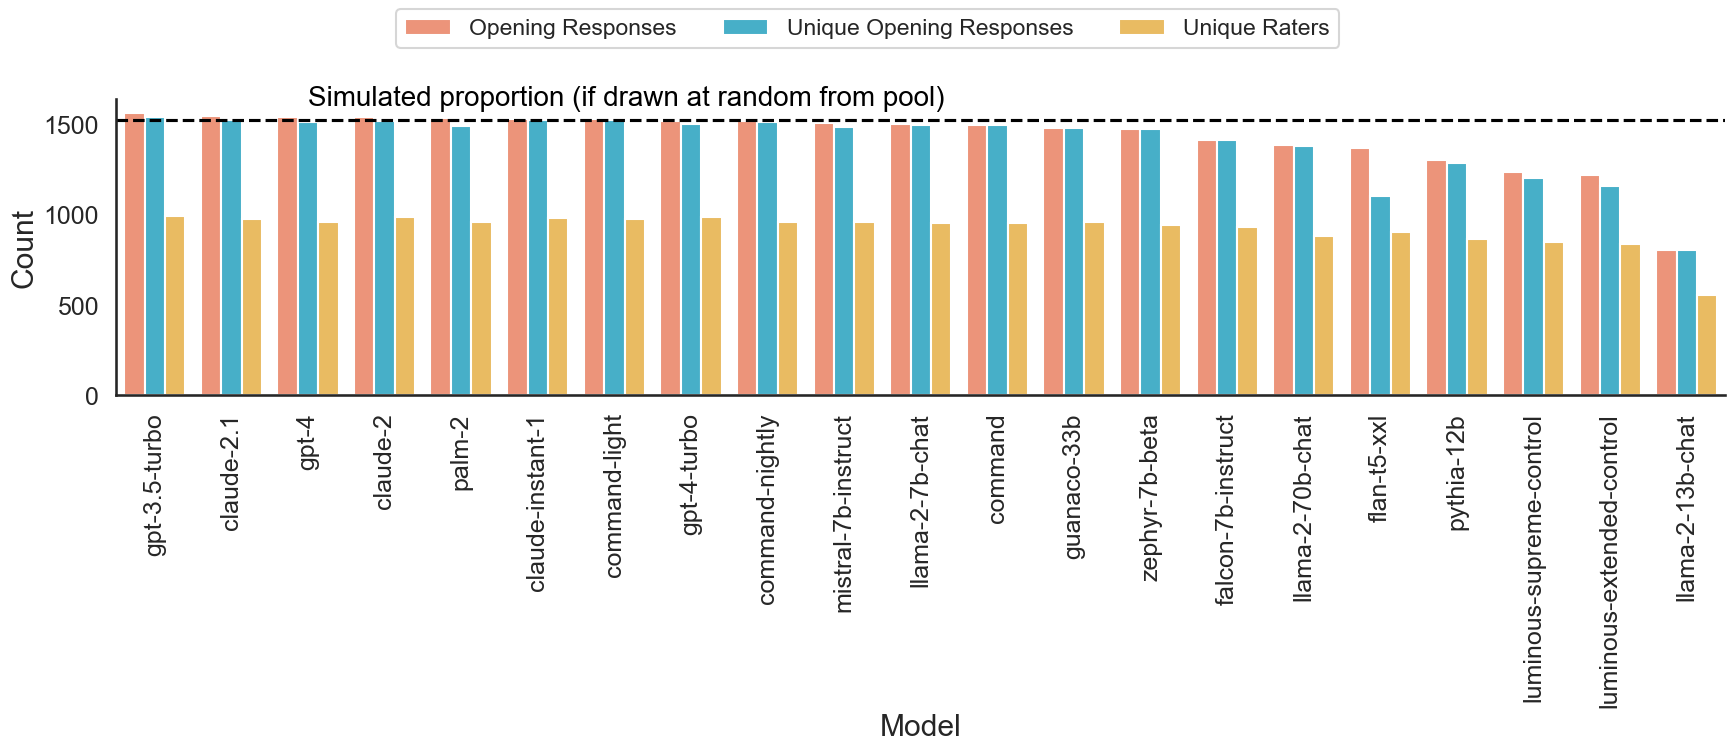

In [14]:
# Now let's see how many we actually got
openers = utterances[utterances["turn"] == 0]
models = utterances["model_name"].unique()
n_openers = []
n_unique_openers = []
n_unique_users = []
models_short = []
for model in models:
    # How many times does this model appear
    n_openers.append(len(openers[openers["model_name"] == model]))
    # How many times did this model respond with a duplicated text
    n_unique_openers.append(
        len(openers[openers["model_name"] == model]["model_response"].unique())
    )
    # How many unique people rated this model
    n_unique_users.append(
        len(openers[openers["model_name"] == model]["user_id"].unique())
    )

# Make dataframe
df = pd.DataFrame(
    {
        "model": models,
        "Opening Responses": n_openers,
        "Unique Opening Responses": n_unique_openers,
        "Unique Raters": n_unique_users,
    }
)
df = df.sort_values(by="Opening Responses", ascending=False)


# Melt the DataFrame to long-format for Seaborn
df_long = df.melt(
    id_vars="model",
    value_vars=["Opening Responses", "Unique Opening Responses", "Unique Raters"],
)

# Create a catplot using Seaborn
g = sns.catplot(
    data=df_long,
    kind="bar",
    x="model",
    y="value",
    hue="variable",
    errorbar=None,
    height=7,
    aspect=2,
)

# Add horizontal line at exp_prop
plt.axhline(y=int(exp_prop), color="black", linestyle="--")
# Add text to explain this line
plt.text(
    2,
    int(exp_prop) + 50,
    "Simulated proportion (if drawn at random from pool)",
    color="black",
    fontsize=20,
    ha="left",
    va="bottom",
)


# Rotate model names to avoid overlap
g.set_xticklabels(rotation=90)

# Adding labels and title
g.set_axis_labels("Model", "Count")

# Adjust the position of the title and show the plot
g.fig.subplots_adjust(top=0.9)
# Change legend to top center with horizontal orientation
g.fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=4)
# Remove other legend
g._legend.remove()
plt.tight_layout()


# Save
plt.savefig(f"{PLOT_PATH}/model_apperances.pdf", bbox_inches="tight", format="pdf")

if SHOW_PLOTS:
    plt.show()

else:
    plt.close()

In [15]:
# Unique models per individual
openers = utterances[utterances["turn"] == 0]
unique_models_per_user = openers.groupby("user_id")["model_name"].nunique()

# Calculate the average number of unique model seen per user
unique_models_per_user.mean()

13.904011461318051

In [16]:
# Average actual appereances
openers["model_name"].value_counts().mean()

1430.904761904762

### Model correlations

Num rows of scores: 68371
Num rows of scores (no NaNs): 68371
Shape of pivot: (8011, 21)


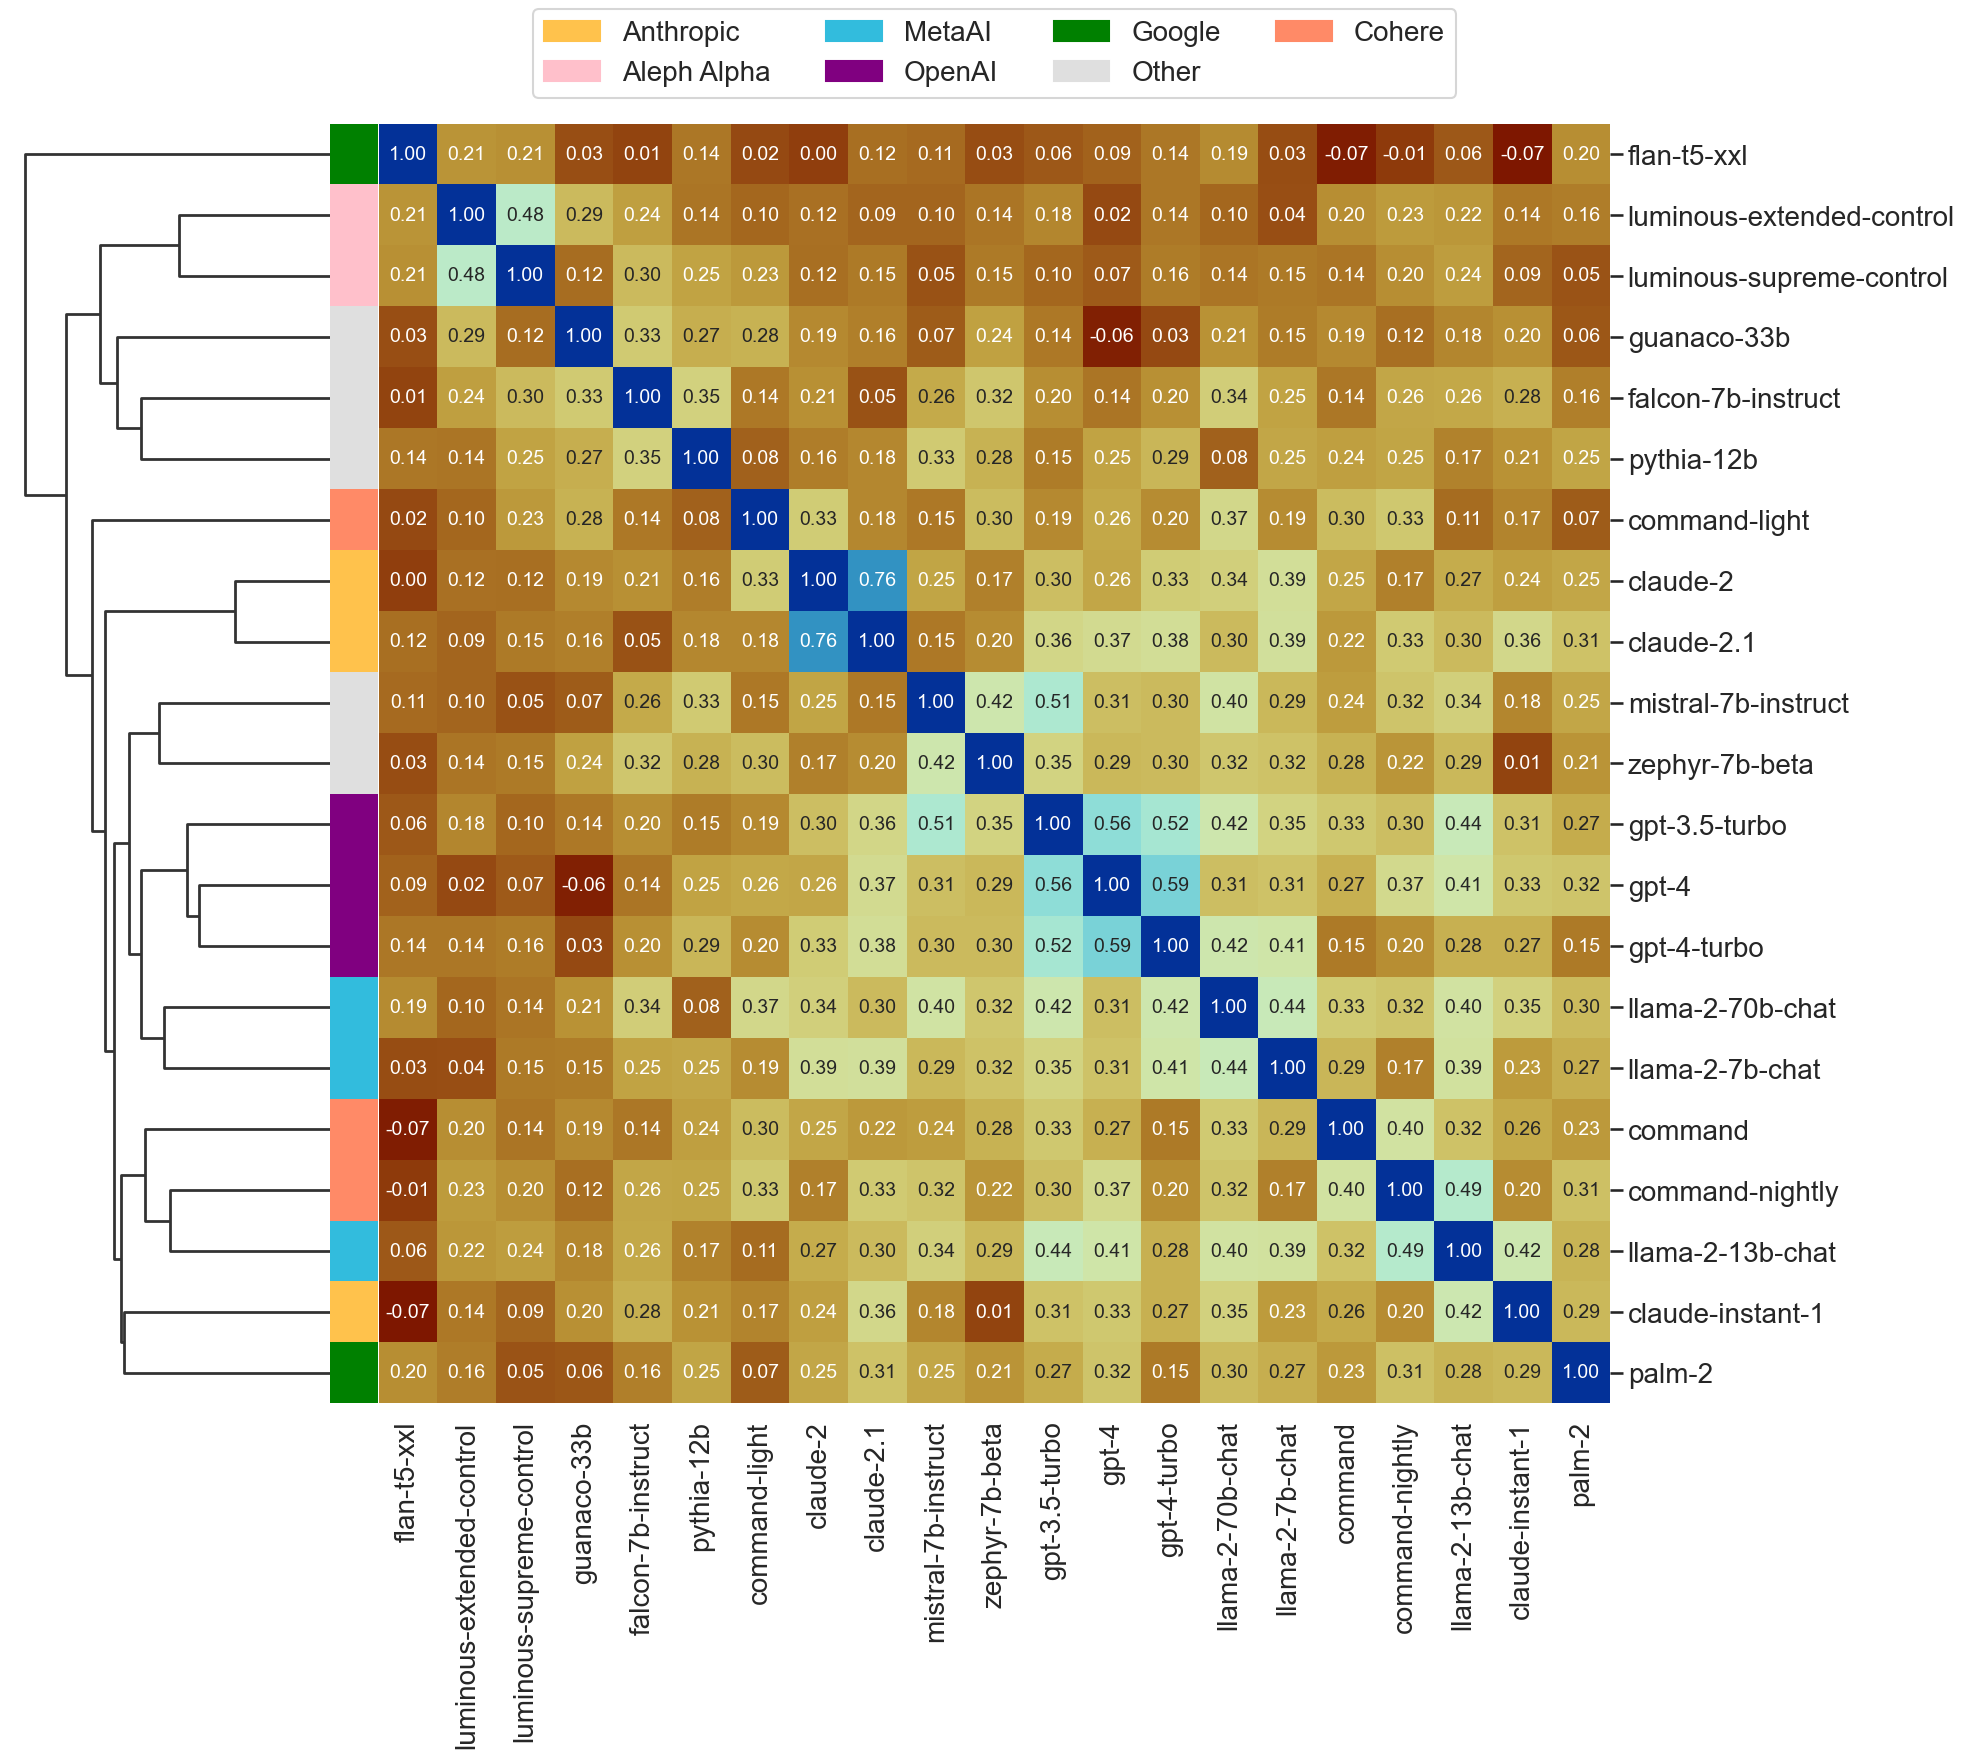

In [17]:
# Get correlations of model scores (controls for loads of things, question, user - sparse but helpful)
model_scores = data_dict["utterances"].copy()
print(f"Num rows of scores: {len(model_scores)}")
# Drop any NaNs (shouldnt be any!)
model_scores = model_scores.dropna(subset=["score"])
print(f"Num rows of scores (no NaNs): {len(model_scores)}")
# Pivot table
model_scores = model_scores.pivot_table(
    index="conversation_id", columns="model_name", values="score"
)
print("Shape of pivot:", model_scores.shape)
model_scores = model_scores.dropna(axis=1, how="all")
model_scores = model_scores.dropna(axis=0, how="all")
# Now take within convo correlations
model_scores = model_scores.corr()

# Set row colors based on col stub (model family)
row_colors = []
providers = []
for col in model_scores.columns:
    if "claude" in col:
        row_colors.append(basic_colors_dict["yellow"])
        providers.append("Anthropic")
    elif "gpt" in col:
        row_colors.append("purple")
        providers.append("OpenAI")
    elif "llama" in col:
        row_colors.append(basic_colors_dict["blue"])
        providers.append("MetaAI")
    elif "luminous" in col:
        row_colors.append("pink")
        providers.append("Aleph Alpha")
    elif col in ["palm-2", "flan-t5-xxl"]:
        row_colors.append("green")
        providers.append("Google")
    elif "command" in col:
        row_colors.append(basic_colors_dict["red"])
        providers.append("Cohere")
    else:
        row_colors.append(basic_colors_dict["mid_grey"])
        providers.append("Other")

plt.ion()
# Cluster map
clustergrid = sns.clustermap(
    model_scores,
    cbar_pos=None,
    annot=True,
    annot_kws={"size": 14},
    fmt=".2f",
    cmap=palettes_dict["roma"],
    figsize=(20, 20),
    row_colors=row_colors,
    tree_kws={"linewidth": 2},
)
clustergrid.ax_col_dendrogram.set_visible(False)
clustergrid.ax_heatmap.tick_params(axis="both", labelsize=20)

# Add patches for providers
patches = []
# Map unique providers to unique colors
provider_color_mapping = dict(zip(providers, row_colors))
for provider, color in provider_color_mapping.items():
    patch = mpatches.Patch(color=color, label=provider)
    patches.append(patch)

# Reverse order of patches
patches = patches[::-1]
# Make sure "Other" is at the end
patches = [patches[-1]] + patches[:-1]

# Add legend
plt.legend(
    handles=patches, loc="upper center", fontsize=20, bbox_to_anchor=(0.5, 1.1), ncols=4
)

# Turn off y-axis label
plt.ylabel("")
plt.xlabel("")

# Save
plt.savefig(
    f"{PLOT_PATH}/model_correlation_clustermap.pdf", bbox_inches="tight", format="pdf"
)

if SHOW_PLOTS:
    plt.show()

else:
    plt.close()

### Get Pairwise Battles

In [18]:
# Only for opening turn
openers = interactions[interactions["turn"] == 0]
battles = pd.DataFrame(extract_battles(openers, tie_thresh=5))
display(battles.head())

# Remove ties
battles_no_ties = battles[~battles["winner"].str.contains("tie")]

# Value counts
print(len(battles))
print(battles["winner"].value_counts(normalize=True))

model_a  score_a           model_b  score_b   winner
0     flan-t5-xxl     17.0     command-light     92.0  model_b
1      claude-2.1     65.0    zephyr-7b-beta     83.0  model_b
2      claude-2.1     65.0       guanaco-33b     40.0  model_a
3      claude-2.1     65.0  llama-2-70b-chat     24.0  model_a
4  zephyr-7b-beta     83.0       guanaco-33b     40.0  model_a

42306
winner
model_a    0.421902
model_b    0.403323
tie        0.174774
Name: proportion, dtype: float64


## Elo Score

### Naive ELO

In [19]:
# Compute ELO
elo_scores = compute_elo(battles)

# Convert ELO to DataFrame
elo_df = pd.DataFrame.from_dict(elo_scores, orient="index", columns=["elo"])
display(elo_df.sort_values(by="elo", ascending=False))

elo
command                    1140.792892
zephyr-7b-beta             1122.244544
command-nightly            1087.330192
llama-2-7b-chat            1080.534993
claude-instant-1           1074.999657
palm-2                     1062.598462
llama-2-70b-chat           1051.951779
command-light              1047.641461
gpt-4-turbo                1032.913892
llama-2-13b-chat           1028.281573
gpt-4                      1026.183484
mistral-7b-instruct        1020.545816
claude-2.1                 1017.889264
claude-2                   1001.806631
gpt-3.5-turbo               993.737307
guanaco-33b                 991.953783
pythia-12b                  976.634697
falcon-7b-instruct          959.649913
luminous-extended-control   790.549785
luminous-supreme-control    777.167326
flan-t5-xxl                 714.592551

### Instability of ELO to "Tournament"

In [20]:
# Absolute score sensitive to order of games ("recency bias")
elo_normal = compute_elo(battles)
elo_reverse = compute_elo(battles.iloc[::-1])
combined = pd.DataFrame.from_records([elo_normal, elo_reverse]).T
combined.columns = ["normal", "reverse"]
combined.sort_values(by="normal", ascending=False)

normal      reverse
command                    1140.792892  1141.436886
zephyr-7b-beta             1122.244544  1098.483491
command-nightly            1087.330192  1063.994702
llama-2-7b-chat            1080.534993  1073.993158
claude-instant-1           1074.999657  1076.827634
palm-2                     1062.598462  1099.519889
llama-2-70b-chat           1051.951779  1035.935185
command-light              1047.641461  1041.708851
gpt-4-turbo                1032.913892  1074.701627
llama-2-13b-chat           1028.281573  1007.454921
gpt-4                      1026.183484  1015.575925
mistral-7b-instruct        1020.545816   989.313502
claude-2.1                 1017.889264  1025.690327
claude-2                   1001.806631  1022.942480
gpt-3.5-turbo               993.737307  1017.365211
guanaco-33b                 991.953783  1044.192461
pythia-12b                  976.634697   918.682404
falcon-7b-instruct          959.649913   945.430282
luminous-extended-control   790.549785   809.332573
luminous-supreme-control    777.167326   787.570985
flan-t5-xxl                 714.592551   709.847506

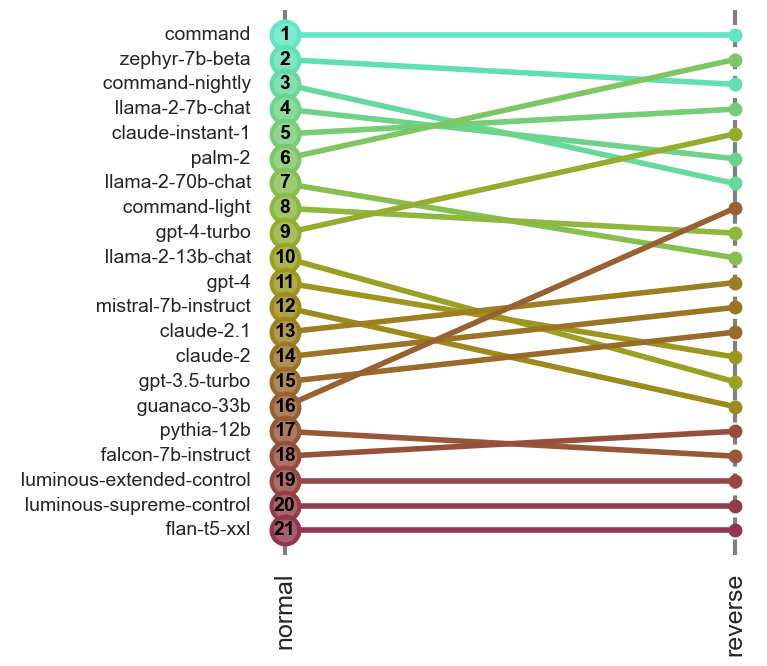

In [21]:
# Plotting
rank_df = score2rank(combined, multimetric=False, metric_name="elo_score")
parallel_plot_from_rank_df(
    rank_df, figsize=(8, 7), palette="hawaii", save_name="elo_instability"
)

### Boostrap ELO (MLE)

In [22]:
bootstrap_df = get_bootstrap_result(battles, compute_mle_elo, num_round=BOOTSTRAP_ITER)
elo_rating_median = get_median_elo_from_bootstrap(bootstrap_df)

bootstrap:   1%|          | 7/1000 [00:02<06:42,  2.47it/s]

bootstrap: 100%|██████████| 1000/1000 [01:55<00:00,  8.65it/s]


In [23]:
# Convert ELO to DataFrame
elo_df = pd.DataFrame.from_dict(elo_rating_median, orient="index", columns=["elo"])
display(elo_df.sort_values(by="elo", ascending=False))

elo
command                    1208
claude-instant-1           1166
zephyr-7b-beta             1164
palm-2                     1156
llama-2-7b-chat            1147
llama-2-70b-chat           1133
gpt-4-turbo                1131
command-nightly            1124
command-light              1102
gpt-4                      1100
gpt-3.5-turbo              1091
guanaco-33b                1088
llama-2-13b-chat           1087
claude-2                   1085
mistral-7b-instruct        1076
claude-2.1                 1073
pythia-12b                 1032
falcon-7b-instruct         1029
luminous-supreme-control    894
luminous-extended-control   871
flan-t5-xxl                 800

### Summary Plots

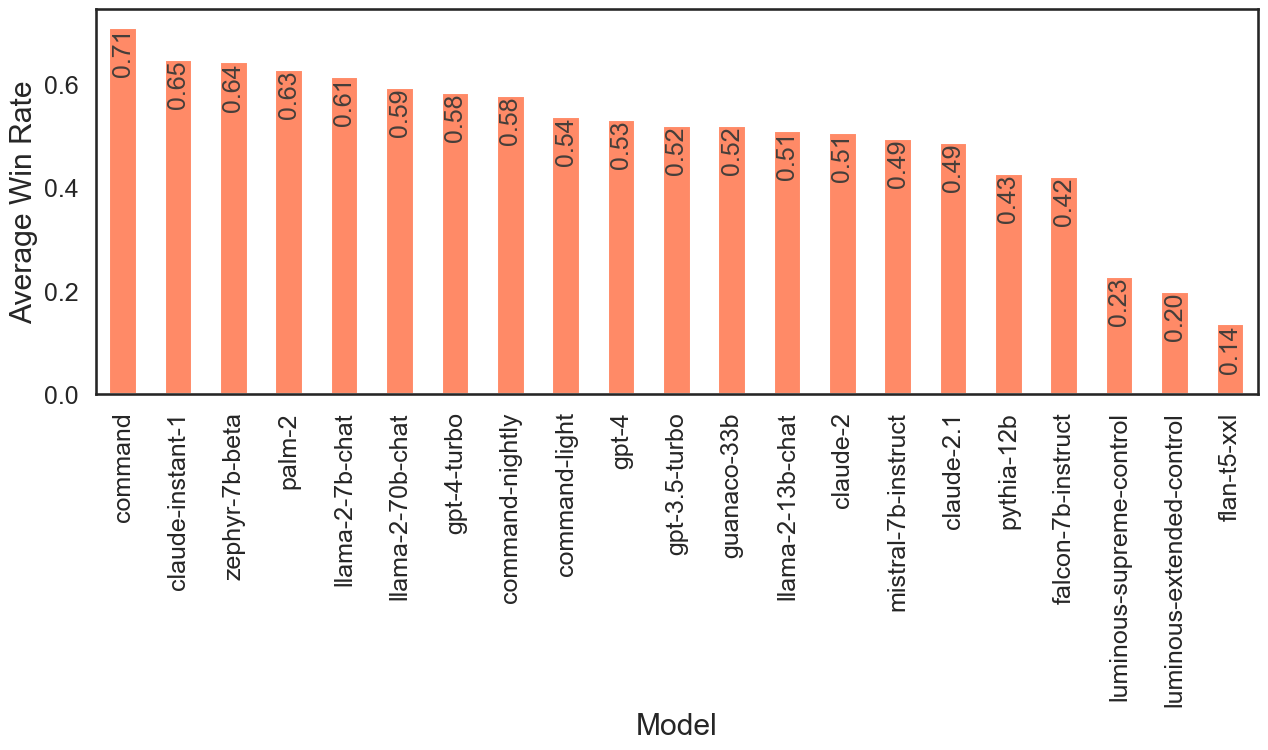

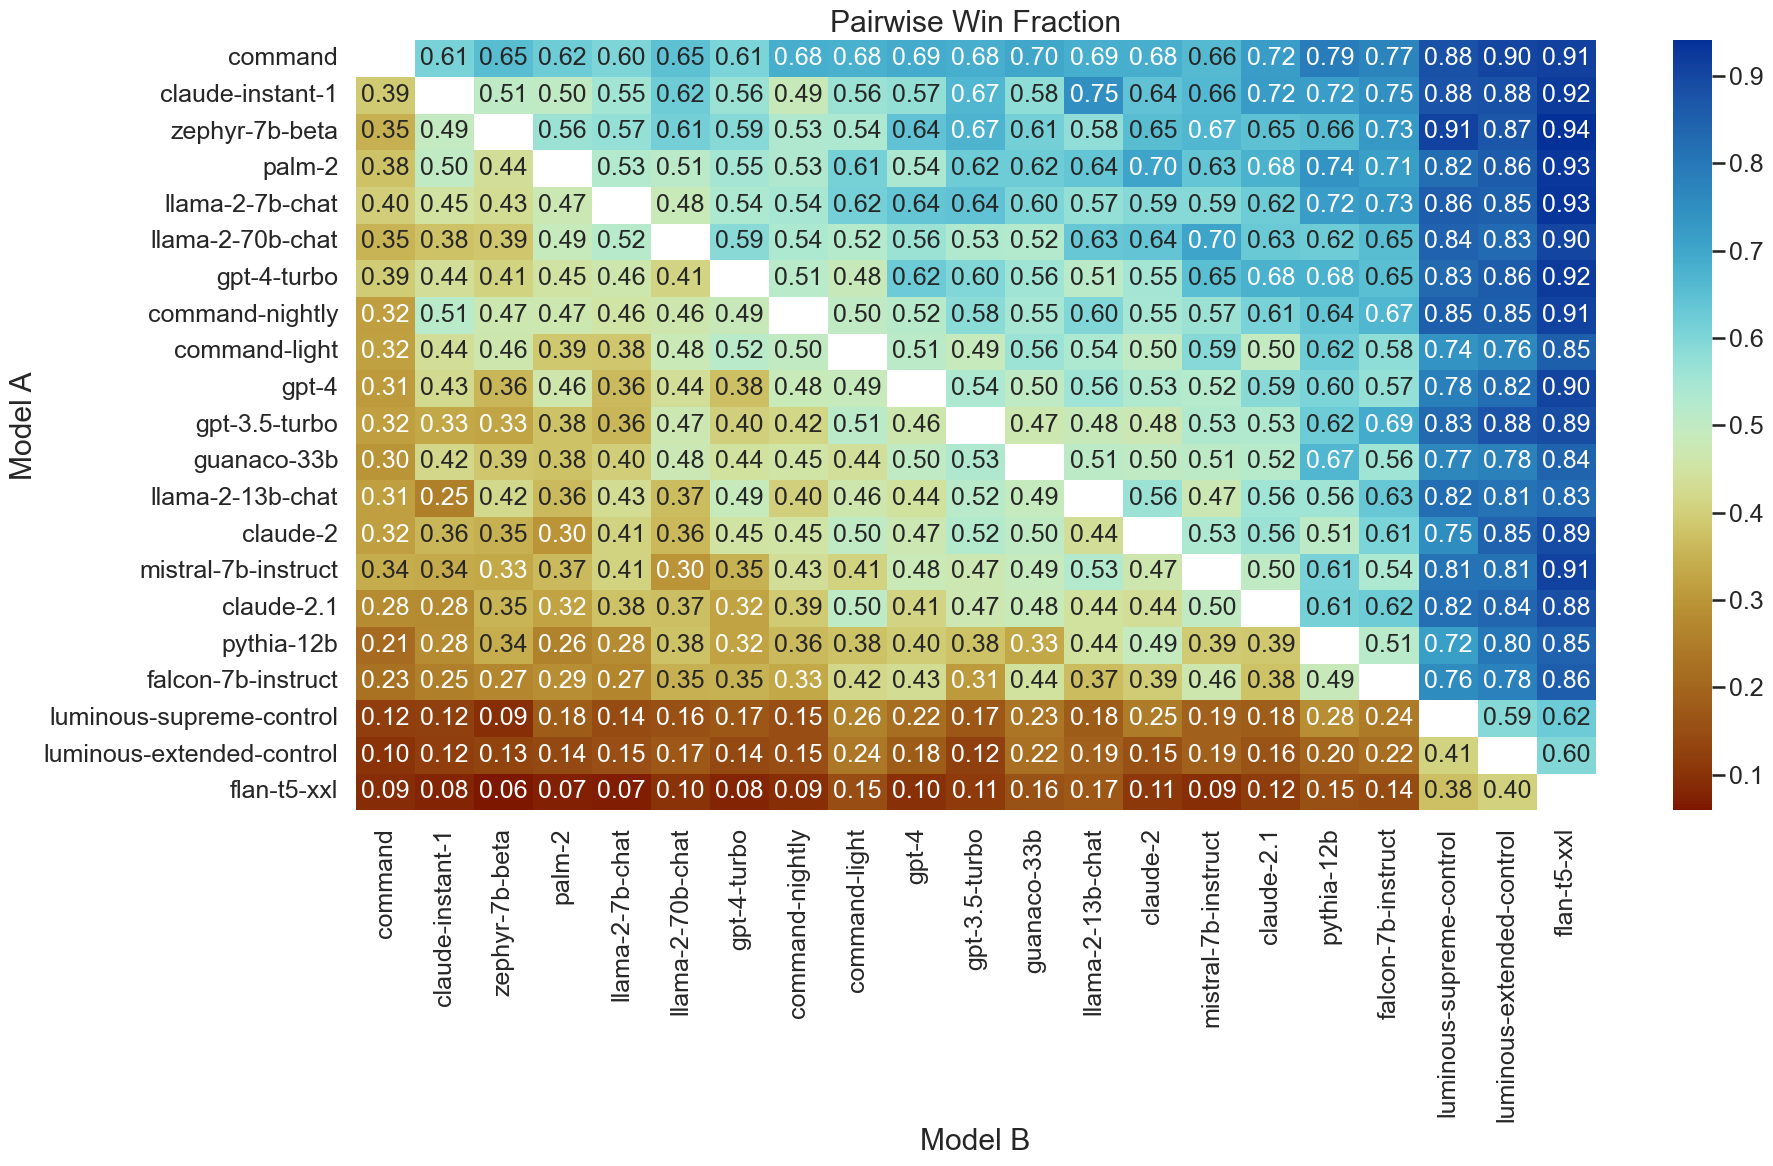

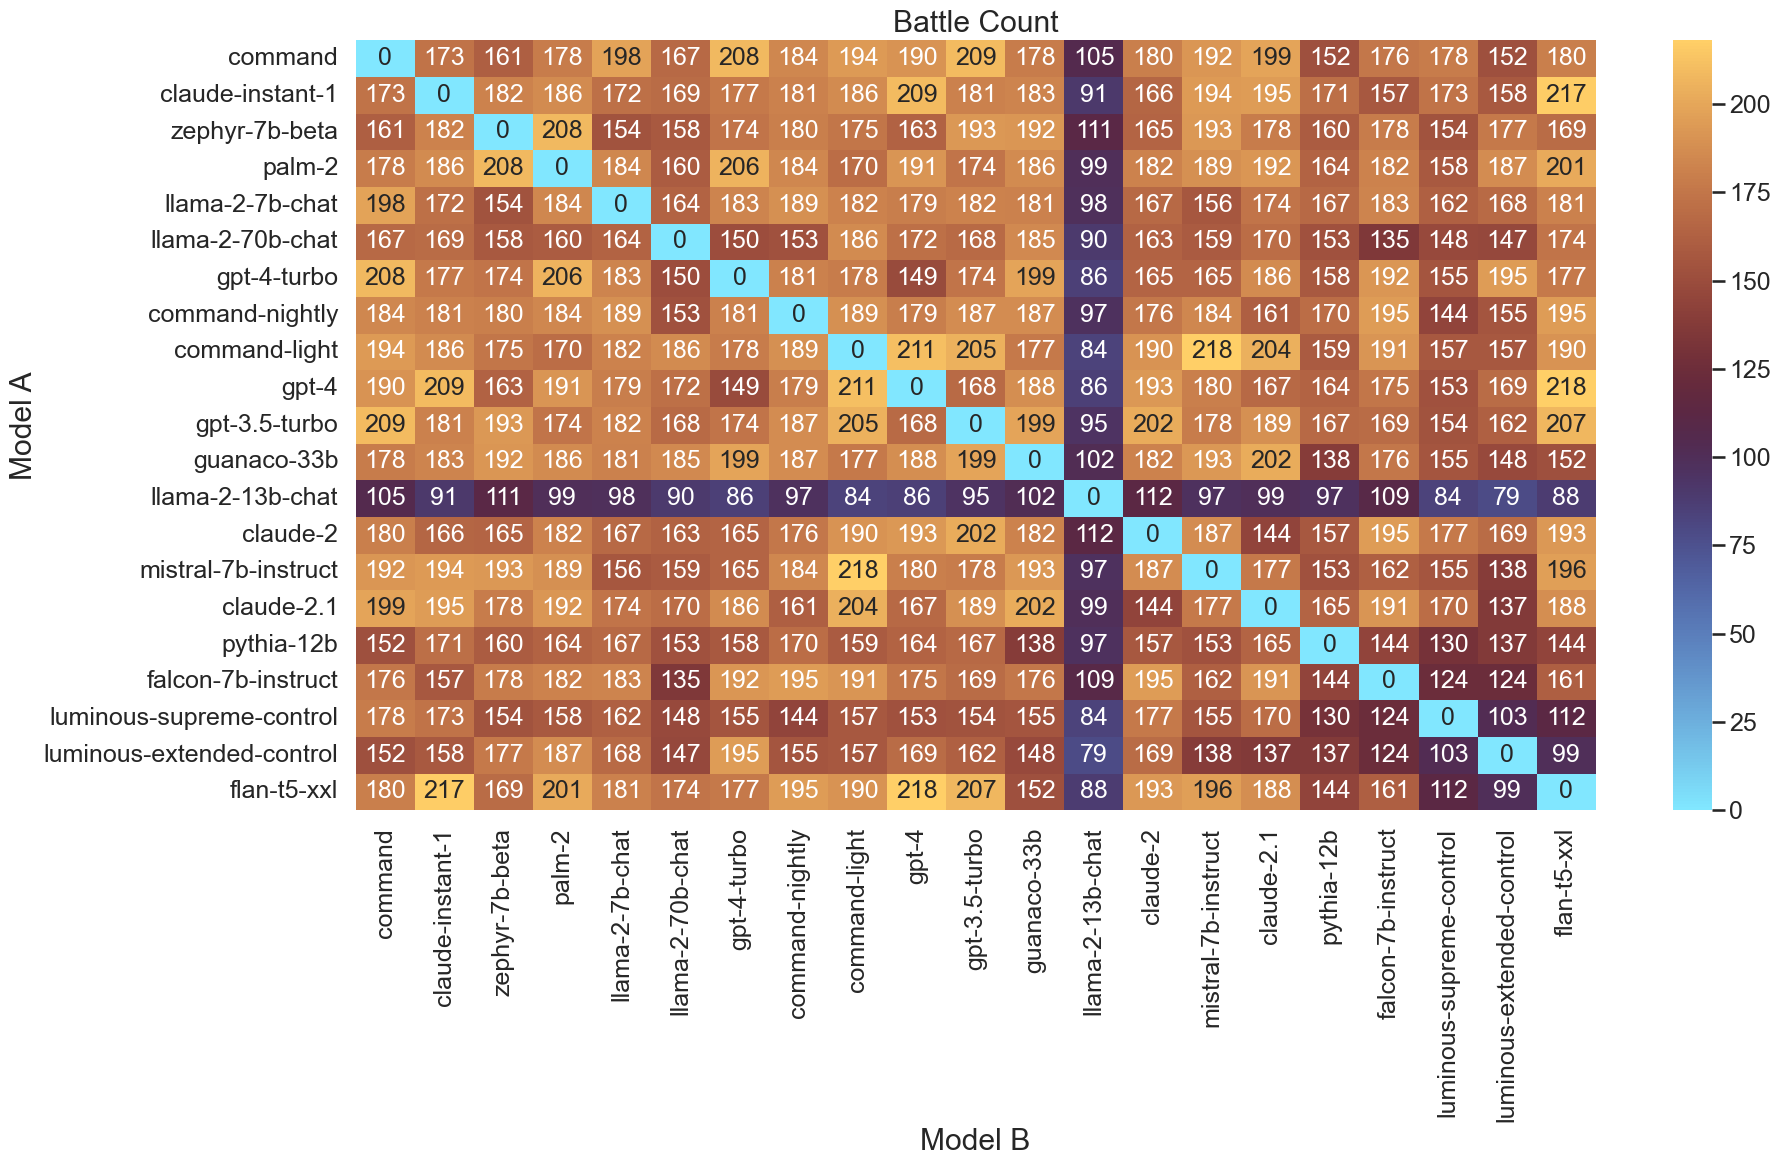

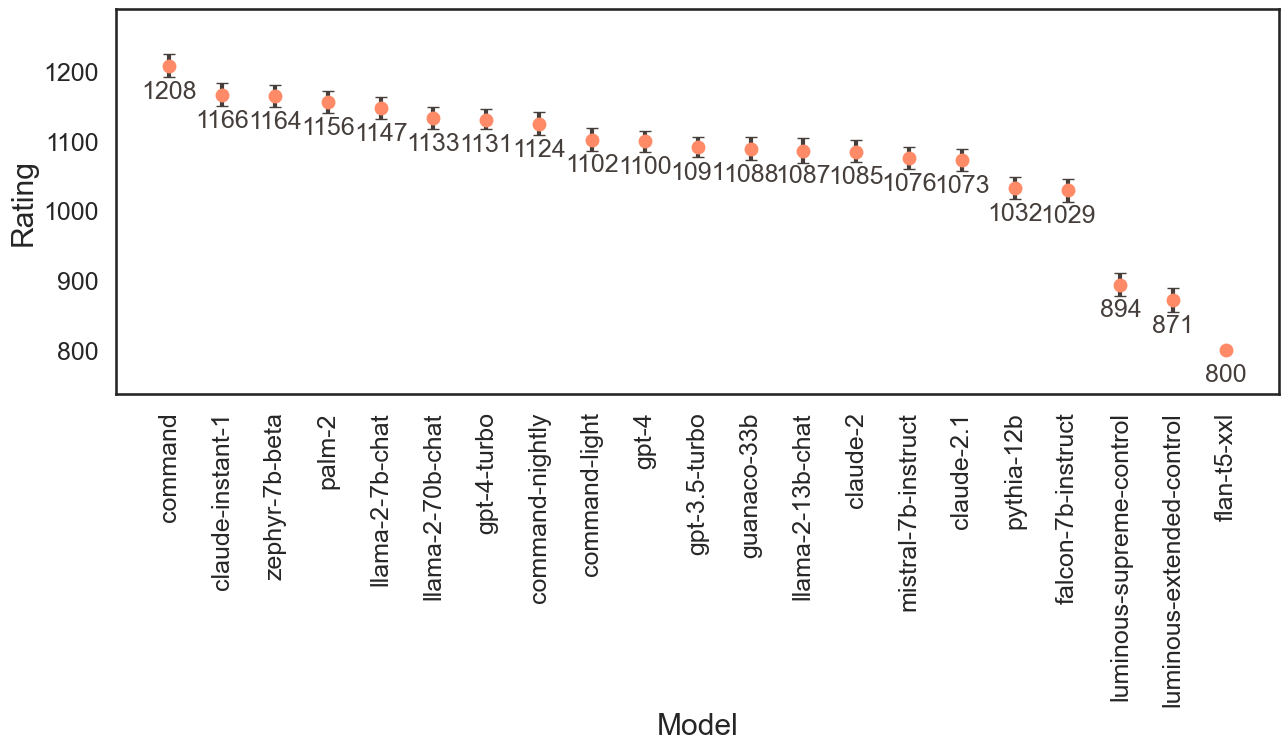

In [24]:
# Plots
limit_show_number = 21  # All our models
average_win_rates = visualize_average_win_rate_matplotlib(
    battles_no_ties, limit_show_number
)

# Sort by average win rate
model_order = list(average_win_rates.index)

# Pairwise win fractions
win_fraction_heatmap = visualize_pairwise_win_fraction_matplotlib(
    battles_no_ties, model_order, save_plot=True
)

# Pairwise battle count
battle_count_heatmap = visualize_battle_count_matplotlib(
    battles_no_ties, model_order, save_plot=True
)

# Bootstrap Elo Rating (as they do for the LMSYS leaderboard)
bootstrap_elo_rating = visualize_bootstrap_elo_rating_matplotlib(
    bootstrap_df, limit_show_number
)

## Sensitivity of Model Ranks to Choice of Metric

In [25]:
# Keep just the openers at utterance level (we need these for win_rates)
openers = utterances[utterances["turn"] == 0]

# Get battles from wide format (also opening opening turn)
battles = pd.DataFrame(
    extract_battles(interactions[interactions["turn"] == 0], tie_thresh=5)
)
####################################
# COMPUTE A VARIETY OF AGGREAGATION FUNCTIONS FOR GOING FROM BATTLES TO MODEL RANKS
####################################

# Shuffle order
battles = battles.sample(frac=1, random_state=42, replace=False)
# Calculate naive Elo
elo_naive = compute_elo(battles)
# Shuffle again!
battles = battles.sample(frac=1, random_state=43, replace=False)
# Calculate naive Elo again!
elo_naive_reverse = compute_elo(battles)

# Elo MLE
elo_score = compute_mle_elo(battles, worst_model="flan-t5-xxl")

# Rank Centrality
rc_score = pd.Series(compute_rank_centrality(battles, alpha=1))

# If chosen win rates
win_rates = (
    openers.groupby("model_name")["if_chosen"].value_counts(normalize=True).unstack()
)
# Keep only when True
win_rates = win_rates[True]

# Mean score raw
mean_score = openers.groupby("model_name")["score"].mean()

# Normalised methods
mean_normalized_score = openers.groupby("model_name")["normalized_score_openers"].mean()
mean_within_turn_rank = openers.groupby("model_name")["within_turn_rank"].mean()

# Merge into a single dataframe
model_metrics = pd.DataFrame.from_records(
    [
        elo_naive,
        elo_naive_reverse,
        elo_score,
        rc_score,
        win_rates,
        mean_score,
        mean_normalized_score,
        mean_within_turn_rank,
    ]
).T
model_metrics.columns = [
    "elo_naive",
    "elo_naive_reverse",
    "elo_score",
    "rank_centrality_score",
    "win_rate",
    "mean_score",
    "mean_normalized_score",
    "mean_within_turn_rank",
]

In [26]:
# Convert into ranks so we can combine them
combined_rank_df = score2rank(model_metrics, multimetric=True)

In [27]:
# Reorder
order = [
    "rank_centrality_score",
    "elo_naive",
    "elo_naive_reverse",
    "elo_score",
    "win_rate",
    "mean_score",
    "mean_normalized_score",
    "mean_within_turn_rank",
]
combined_rank_df = combined_rank_df[order]
combined_rank_df.head(2)

rank_centrality_score  elo_naive  elo_naive_reverse  \
claude-instant-1                    2.0        2.0                3.0   
palm-2                              3.0        5.0                4.0   

                  elo_score  win_rate  mean_score  mean_normalized_score  \
claude-instant-1        2.0       3.0         2.0                    2.0   
palm-2                  4.0       4.0         3.0                    3.0   

                  mean_within_turn_rank  
claude-instant-1                    2.0  
palm-2                              4.0

In [28]:
# Neater names
combined_rank_df.columns = [
    "Pairwise Rank Centrality",
    "Elo (Naive)",
    "Elo (Naive, Reverse)",
    "Elo (BT, MLE)",
    "Average Win Rate",
    "Mean Score",
    "Mean Normalised Score",
    "Mean Within Turn Rank",
]

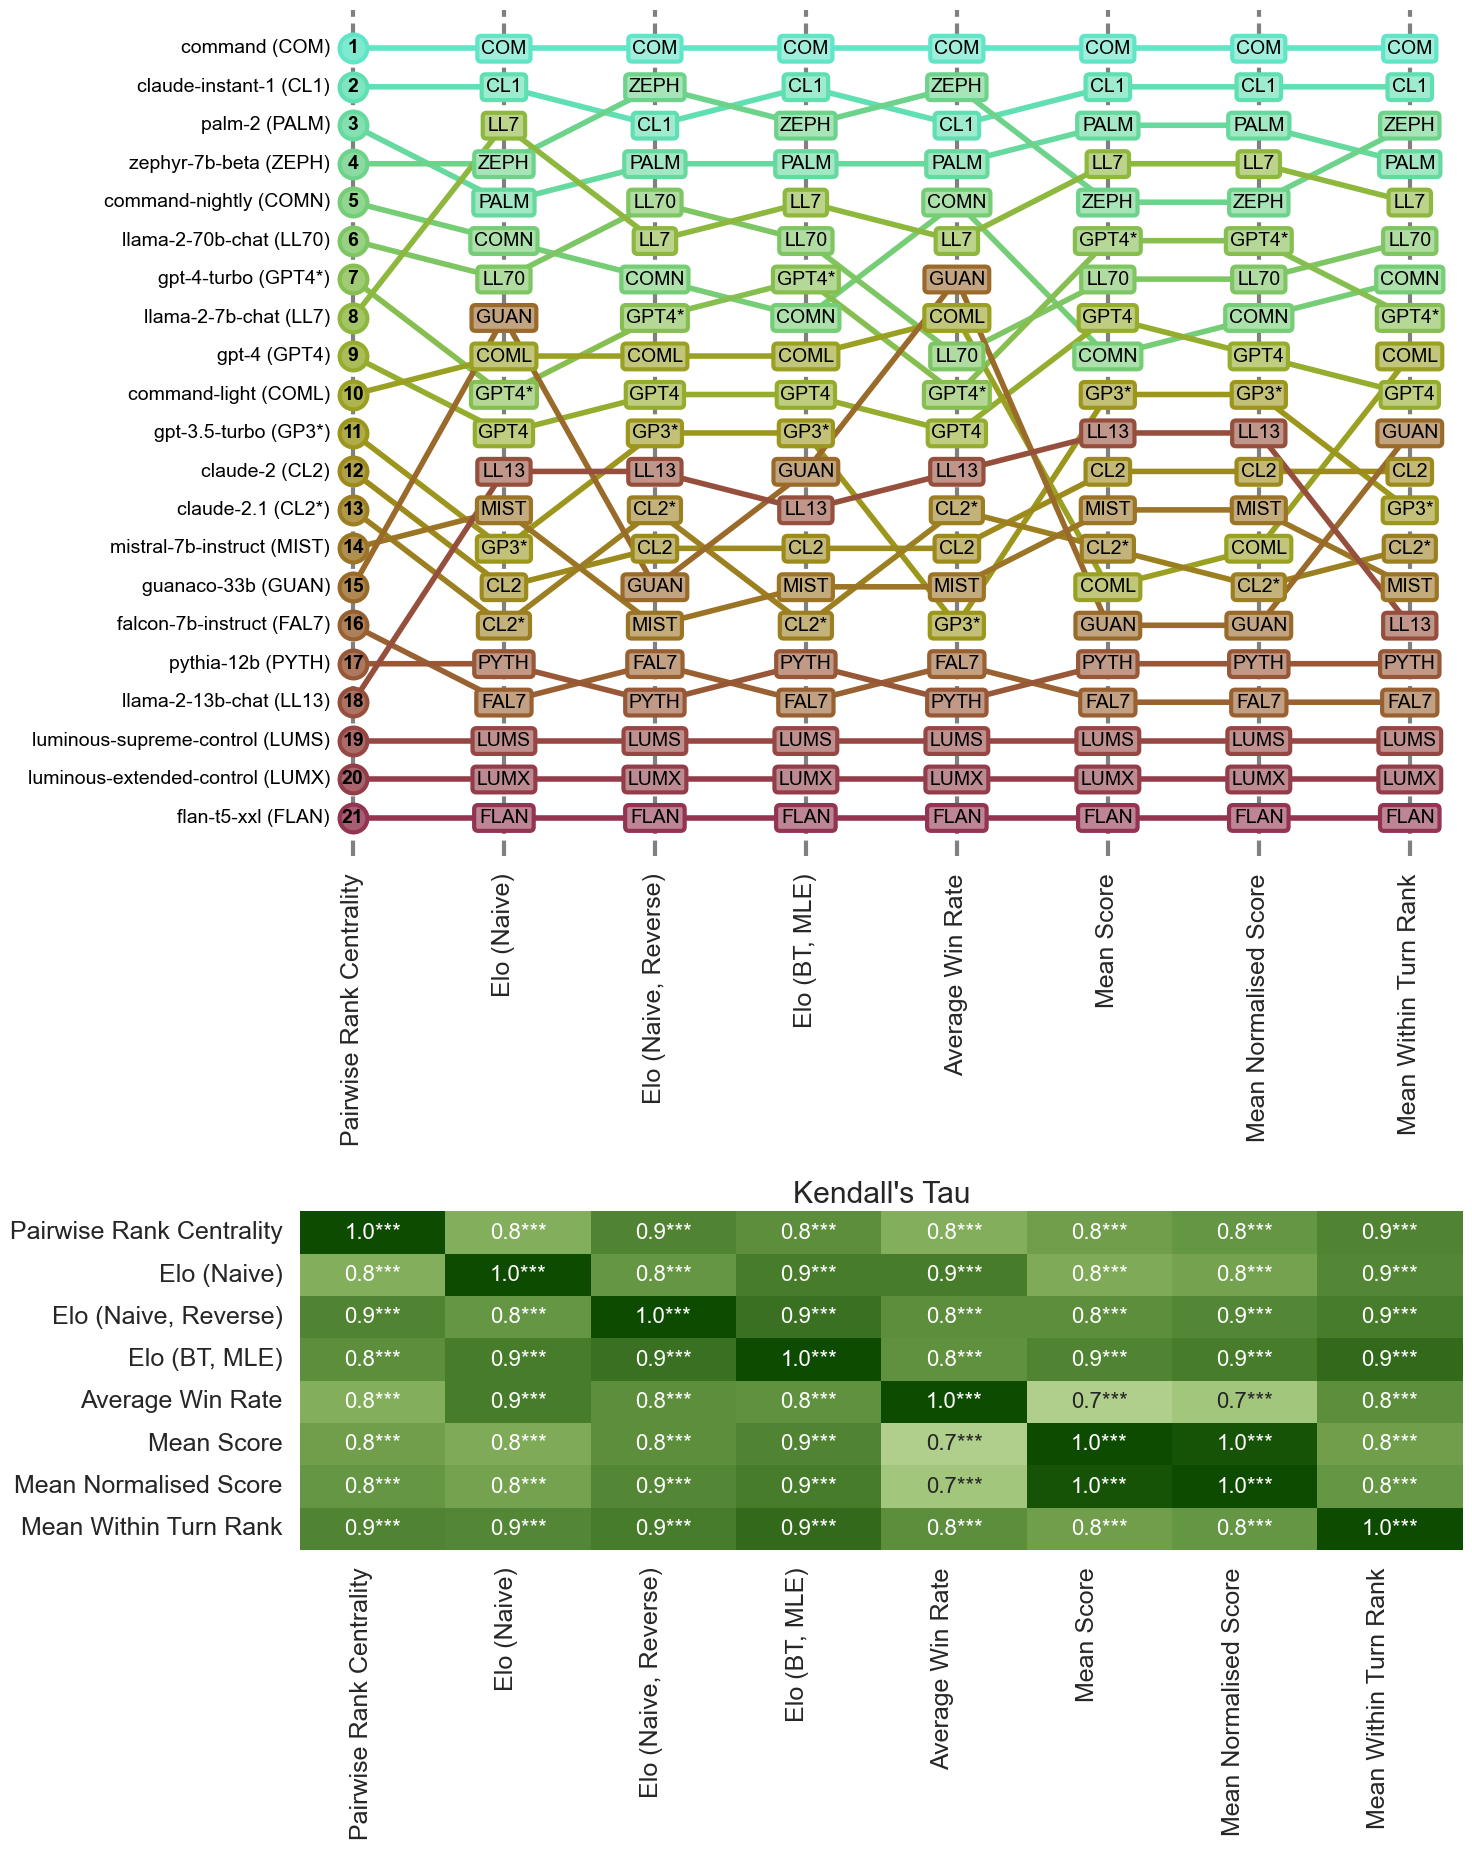

In [29]:
pp = combined_plot_from_rank_df(
    combined_rank_df,
    figsize=(15, 20),
    palette="hawaii",
    label_markers=True,
    save_name="metric_sensitivity",
)

## Sensitivity of Rank Metrics to Tie Threshold

### Basic distribution

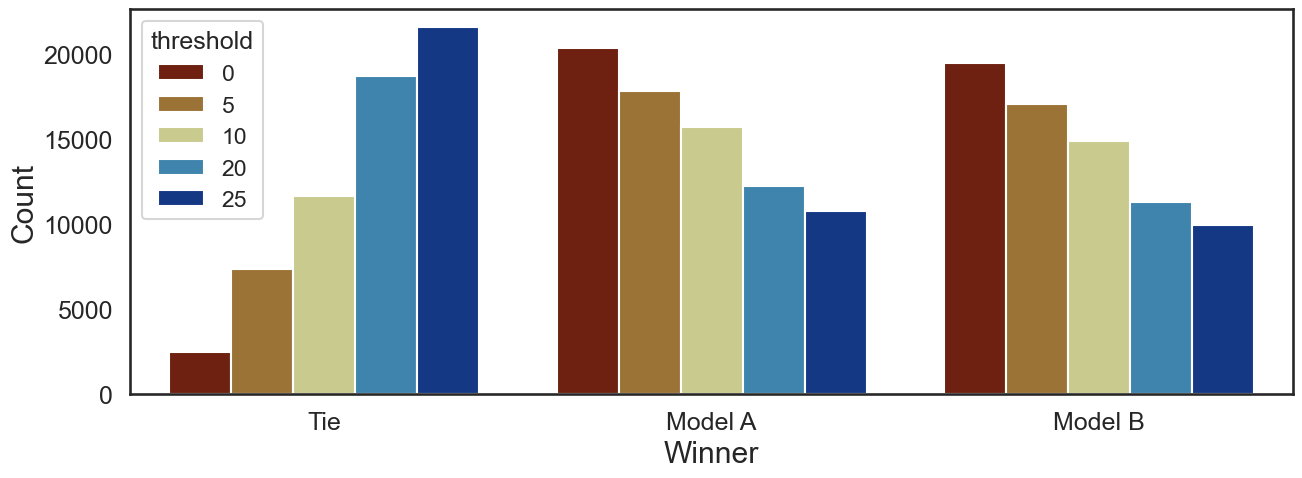

In [30]:
# Only openers
openers = interactions[interactions["turn"] == 0]
metrics = ["elo_score", "rank_centrality_score"]
# Test a variety of possible thresholds
tie_thresholds = [0, 5, 10, 20, 25]

# First lets examine how distribution between absolute winners vs ties differs
combined_counts = []
for tie_thresh in tie_thresholds:
    # Get battles
    battles = pd.DataFrame(extract_battles(openers, tie_thresh=tie_thresh))
    counts = battles["winner"].value_counts()
    count_df = pd.Series(counts, name=tie_thresh)
    combined_counts.append(count_df)

# Combine into a single dataframe
combined_df = pd.concat(combined_counts, axis=1)
unstacked_df = (
    combined_df.reset_index()
    .melt(
        id_vars="winner",
        value_vars=tie_thresholds,
        var_name="threshold",
        value_name="value",
    )
    .sort_values(by=["value", "threshold"], ascending=False)
)

unstacked_df["winner"] = unstacked_df["winner"].map(
    lambda x: x.replace("_", " ").title()
)

# Make a barplot
plt.figure(figsize=(15, 5))
ax = sns.barplot(
    x="winner",
    y="value",
    hue="threshold",
    data=unstacked_df,
    palette=palettes_dict["roma"],
)
plt.xlabel("Winner")
plt.ylabel("Count")
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

### Variability by metric

In [31]:
# Show tie threshold changes over two major aggregation functions (elo mle, rank centrality)
store = {}
for metric in metrics:
    store[metric] = {}
    combined_scores = []
    # Loop through tie thresholds
    for tie_thresh in tie_thresholds:
        battles = pd.DataFrame(extract_battles(openers, tie_thresh=tie_thresh))
        if metric == "elo_score":
            scores = compute_mle_elo(battles, worst_model="flan-t5-xxl")
        elif metric == "rank_centrality_score":
            scores = compute_rank_centrality(battles)
        df = pd.Series(scores, name=f"thresh={tie_thresh}")
        combined_scores.append(df)

    # Get rank df
    combined_df = pd.concat(combined_scores, axis=1)
    rank_df = score2rank(combined_df, multimetric=False, metric_name=metric)
    store[metric]["rank"] = rank_df
    store[metric]["score"] = combined_df

elo_score


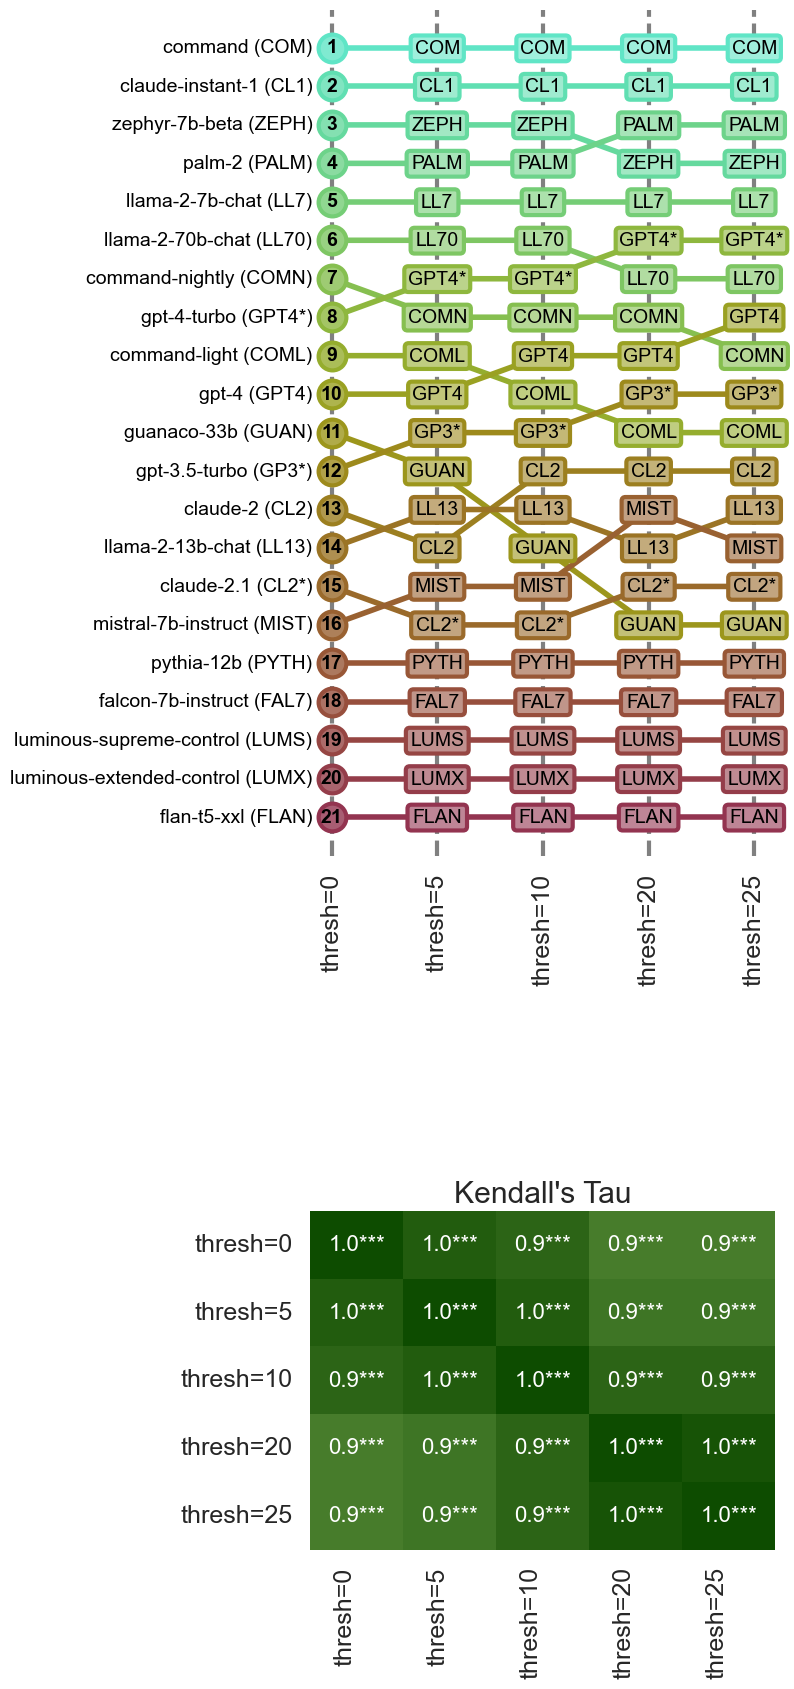

rank_centrality_score


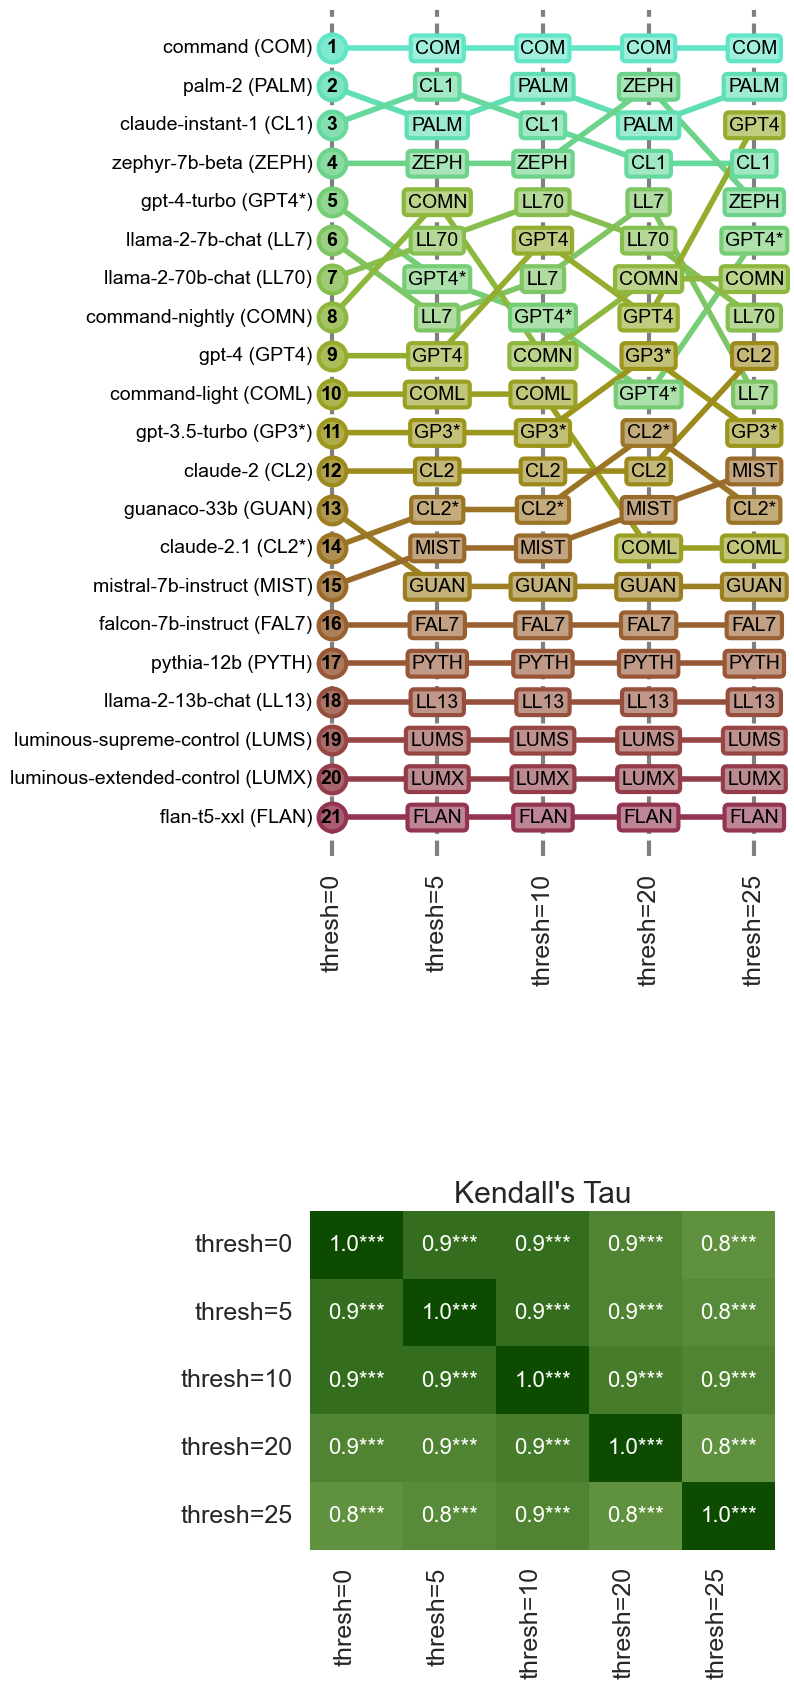

In [32]:
palettes = ["hawaii", "hawaii"]
# Get a comvined plot for each metric
for i, metric in enumerate(store.keys()):
    print(metric)
    pp = combined_plot_from_rank_df(
        store[metric]["rank"],
        figsize=(6, 20),
        palette=palettes[i],
        label_markers=True,
        save_name=f"tie_{metric.split('_')[0]}",
    )

In [33]:
# Clean up
del store

## Sources of Variation in Model Rank

### Fixing Some Variance

We limit to only people in the balanced subset to limit some variance from "choosing" different convos and not completing a full set across the three treatments (unguided, values guided, controversy guided).

In [34]:
# Prepapre data
openers = interactions[interactions["turn"] == 0]
print(f"There are {len(openers)} opening turns in total")
# First merge conversation data
merge1 = openers.merge(
    conversations[
        ["conversation_id", "conversation_type", "included_in_balanced_subset"]
    ],
    on="conversation_id",
    how="left",
)
# Subset only to included in balanced subset
merge1 = merge1[merge1["included_in_balanced_subset"] == True]
print(f"There are {len(merge1)} opening turns in the balanced subset")
# Now merge the survey
merge2 = merge1.merge(survey, on="user_id", how="left")

# Set up base variables
VALID_USERS = pd.Series(merge2["user_id"].unique())
print(f"There are {len(VALID_USERS)} valid users")
VALID_OPENERS = merge2.copy()

VALID_BATTLES = pd.DataFrame(
    extract_battles(VALID_OPENERS, tie_thresh=5, keep_user_id=True)
)
print(f"There are {len(VALID_BATTLES)} valid battles")

# Segment to valid utterances
VALID_UTTERANCES = utterances[
    (utterances["included_in_balanced_subset"] == True) & (utterances["turn"] == 0)
]
print(f"There are {len(VALID_UTTERANCES)} valid utterances")

There are 8011 opening turns in total
There are 6696 opening turns in the balanced subset
There are 1246 valid users
There are 35320 valid battles
There are 25103 valid utterances


#### Check Sensitivity to Conversations Inclusion Set

In [35]:
# Let's confirm the sensitivity of model rank to including everyone or only the balanced subset
combined_scores = []
for set, utt_df in zip(
    ["All conversations", "Balanced subset"], [utterances, VALID_UTTERANCES]
):
    tmp_interactions = pivot_to_wide_format(utt_df.copy())
    openers = tmp_interactions[tmp_interactions["turn"] == 0]
    battles = pd.DataFrame(extract_battles(openers, tie_thresh=5))
    scores = compute_rank_centrality(battles)
    df = pd.Series(scores, name=f"{set}")
    combined_scores.append(df)

# Get rank df
combined_df = pd.concat(combined_scores, axis=1)
rank_df = score2rank(
    combined_df, multimetric=False, metric_name="rank_centrality_score"
)

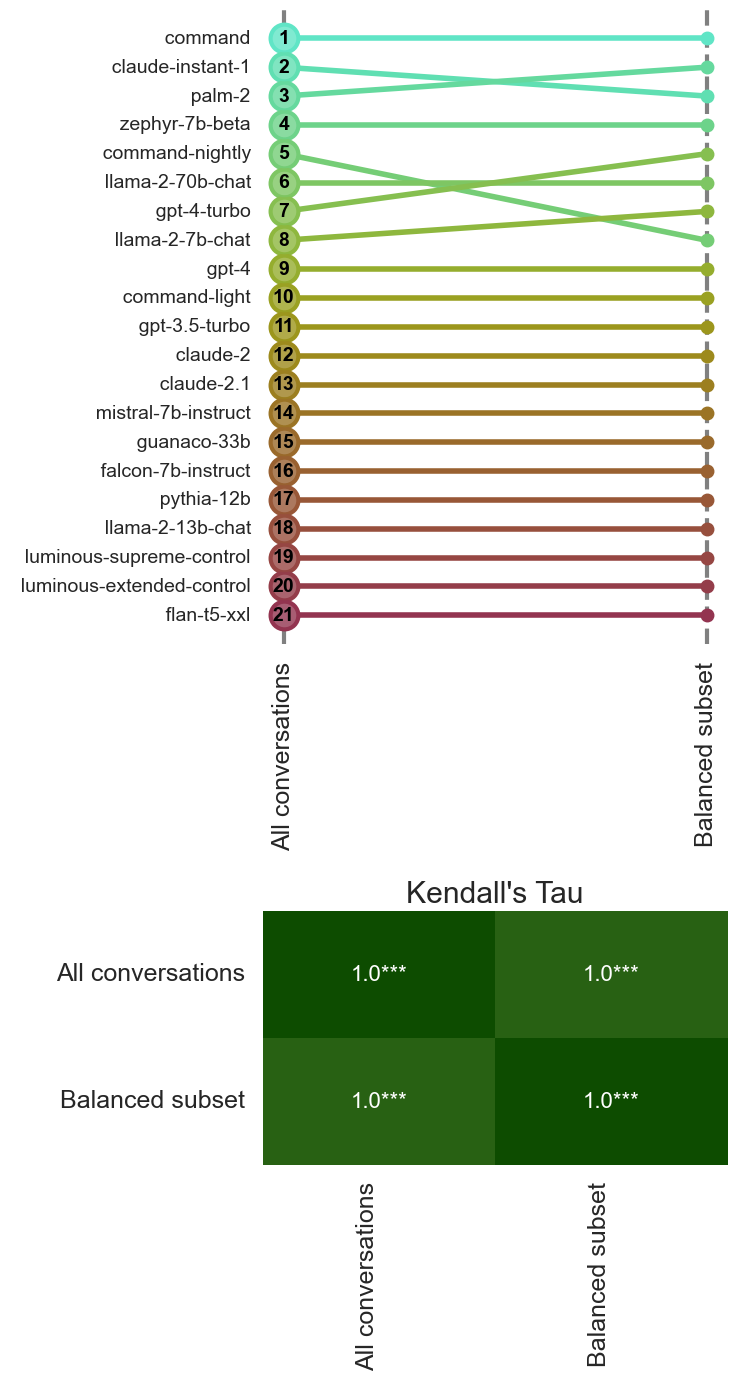

In [36]:
pp = combined_plot_from_rank_df(
    rank_df,
    figsize=(6, 15),
    palette="hawaii",
    label_markers=False,
    save_name=f"balanced_comparison",
)

#### Check Sensitivity to Choice of Regularisation Parameter

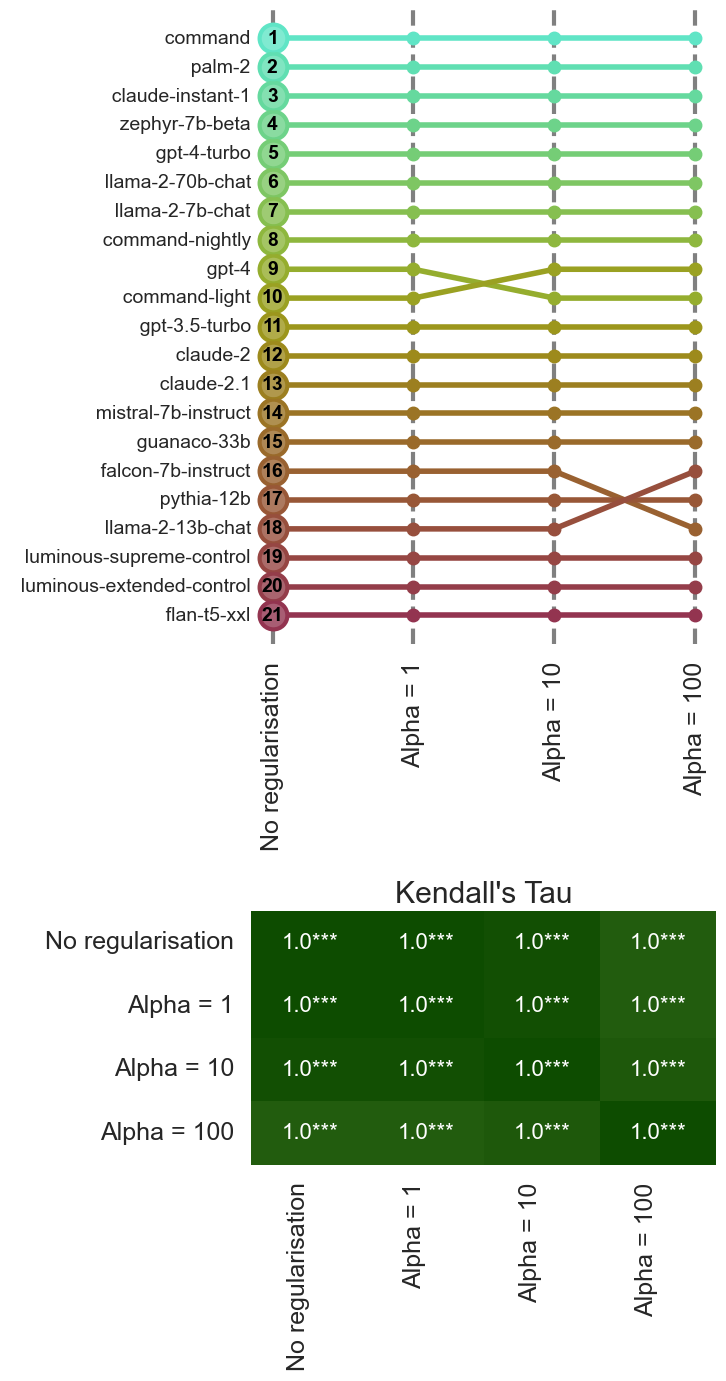

In [37]:
combined_scores = []
for set, alpha in zip(
    ["No regularisation", "Alpha = 1", "Alpha = 10", "Alpha = 100"], [0, 1, 10, 100]
):
    battles = pd.DataFrame(extract_battles(VALID_OPENERS, tie_thresh=5))
    scores = compute_rank_centrality(battles, alpha=alpha)
    df = pd.Series(scores, name=f"{set}")
    combined_scores.append(df)

# Get rank df
combined_df = pd.concat(combined_scores, axis=1)
rank_df = score2rank(
    combined_df, multimetric=False, metric_name="rank_centrality_score"
)
pp = combined_plot_from_rank_df(
    rank_df,
    figsize=(6, 15),
    palette="hawaii",
    label_markers=False,
    save_name=f"regularisation",
)

### Idiosyncratic Variance

In [38]:
def get_idiosyncratic_dists(
    VALID_BATTLES, VALID_USERS, sample_n=100, BOOTSTRAP_ITER=1000
):
    rows = []
    n_openers = []
    n_battles = []
    n_per_pair = []
    n_uids_per_pair = []
    n_utt = []
    n_uids_per_model = []

    # Get base model set
    VALID_BATTLES["pair_list"] = VALID_BATTLES.apply(
        lambda x: sorted([x["model_a"], x["model_b"]]), axis=1
    )
    VALID_BATTLES["pair_string"] = VALID_BATTLES["pair_list"].map(
        lambda x: f"{str(x[0])}vs{str(x[1])}"
    )
    # Find all possible pairs
    all_pairs = VALID_BATTLES["pair_string"].unique()

    # Bootstrap
    for t in tqdm(range(BOOTSTRAP_ITER), desc="bootstrap"):
        # Sample n people
        if sample_n == "all":
            sampled_users = VALID_USERS
        else:
            sampled_users = VALID_USERS.sample(sample_n)
        # Get their battles
        sampled_battles = VALID_BATTLES[VALID_BATTLES["user_id"].isin(sampled_users)]
        # Compute their scores over these battles
        scores = compute_rank_centrality(sampled_battles)
        rows.append(scores)

        # SUMMARY STATS
        n_openers.append(
            len(VALID_OPENERS[VALID_OPENERS["user_id"].isin(sampled_users)])
        )
        n_battles.append(len(sampled_battles))
        n_battles_per_pair = []
        n_users_per_pair = []
        for pair in all_pairs:
            pair_counts = len(sampled_battles[sampled_battles["pair_string"] == pair])
            n_battles_per_pair.append(pair_counts)
            user_counts = sampled_battles["user_id"][
                sampled_battles["pair_string"] == pair
            ].nunique()
            n_users_per_pair.append(user_counts)
        n_per_pair.append(np.mean(n_battles_per_pair))
        n_uids_per_pair.append(np.mean(n_users_per_pair))

        # Get number of unique participant ratings per model
        VALID_UTT_OPENERS = VALID_UTTERANCES[VALID_UTTERANCES["turn"] == 0]
        sampled_utt = VALID_UTT_OPENERS[
            VALID_UTT_OPENERS["user_id"].isin(sampled_users)
        ]
        n_utt.append(len(sampled_utt))

        # Find unique ratings per model
        unique_utt_ratings = sampled_utt.groupby("model_name")["user_id"].nunique()
        n_uids_per_model.append(np.mean(unique_utt_ratings))

    score_df = pd.DataFrame(rows)
    median_scores = score_df.median().sort_values(ascending=False)
    order = median_scores.index
    score_df = score_df[order]
    rank_df = score2rank(
        score_df, multimetric=False, metric_name="rank_centrality_score"
    )

    # SUMMARY STATS TABLE
    count_lsts = [
        n_openers,
        n_battles,
        n_per_pair,
        n_uids_per_pair,
        n_utt,
        n_uids_per_model,
    ]
    count_names = [
        "Number of opening prompts",
        "Number of battles",
        "Number of battles (per possible model pairs)",
        "Number of unique raters (per possible model pairs)",
        "Number of rated model responses",
        "Number of unique raters (per model)",
    ]

    # Save summary
    counts = {}
    for lst, name in zip(count_lsts, count_names):
        counts[name] = lst
    if sample_n == "all":
        sample_n = "All"
    else:
        sample_n = f"N={sample_n}"
    return score_df, rank_df, counts

In [39]:
# Run bootstraps (takes a while!)
store = {}
for i, sample_n in enumerate(["all", 500, 100, 50, 10]):
    score_df, rank_df, counts = get_idiosyncratic_dists(
        VALID_BATTLES, VALID_USERS, sample_n=sample_n, BOOTSTRAP_ITER=BOOTSTRAP_ITER
    )
    store[sample_n] = [score_df, rank_df, counts]

bootstrap:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrap: 100%|██████████| 1000/1000 [00:41<00:00, 24.04it/s]


In [40]:
# Get stats df
for sample_n in store.keys():
    score_df = store[sample_n][0]
    mean = score_df.mean()
    std = score_df.std()
    # Format both with 2dp and commas
    mean = mean.apply(lambda x: f"{x:.2f}")

#### Latex Table

In [41]:
# Initialise
rows = []
index = []
# Loop through different sample sizes
for sample_n in store.keys():
    counts = store[sample_n][2]
    row = {}
    for col, val_list in counts.items():
        mean = np.mean(val_list)
        std = np.std(val_list)
        # Format with commas at 1000
        mean = f"{mean:,.0f}"
        std = f"{std:,.1f}"
        row[col] = f"{mean}\\pm{std}"
    rows.append(row)
    if sample_n == "all":
        index.append(f"$N=1,246$ (All)")
    else:
        index.append(f"$N={sample_n}$")

# Make into df
stats_df = pd.DataFrame(rows, index=index)

# Replace Number with $N$ in columns for nice latex formatting
stats_df.columns = stats_df.columns.str.replace("Number of", "$N$")

# Transpose
stats_df = stats_df.T
display(stats_df)

# Convert to latex
latex_str = stats_df.to_latex(escape=False)
print(latex_str)

$N=1,246$ (All)         $N=500$  \
$N$ opening prompts                              6,696\pm0.0    2,688\pm21.0   
$N$ battles                                     35,320\pm0.0  14,178\pm123.8   
$N$ battles (per possible model pairs)             168\pm0.0        68\pm0.6   
$N$ unique raters (per possible model pairs)       158\pm0.0        64\pm0.5   
$N$ rated model responses                       25,103\pm0.0   10,076\pm81.0   
$N$ unique raters (per model)                      791\pm0.0       318\pm2.0   

                                                   $N=100$        $N=50$  \
$N$ opening prompts                             537\pm11.8     269\pm8.4   
$N$ battles                                   2,834\pm68.7  1,420\pm48.5   
$N$ battles (per possible model pairs)            13\pm0.3       7\pm0.2   
$N$ unique raters (per possible model pairs)      13\pm0.3       6\pm0.2   
$N$ rated model responses                     2,014\pm44.9  1,008\pm31.9   
$N$ unique raters (per model)                     63\pm1.2      32\pm0.8   

                                                  $N=10$  
$N$ opening prompts                             54\pm3.9  
$N$ battles                                   283\pm22.7  
$N$ battles (per possible model pairs)           1\pm0.1  
$N$ unique raters (per possible model pairs)     1\pm0.1  
$N$ rated model responses                     201\pm14.8  
$N$ unique raters (per model)                    6\pm0.4

\begin{tabular}{llllll}
\toprule
 & $N=1,246$ (All) & $N=500$ & $N=100$ & $N=50$ & $N=10$ \\
\midrule
$N$ opening prompts & 6,696\pm0.0 & 2,688\pm21.0 & 537\pm11.8 & 269\pm8.4 & 54\pm3.9 \\
$N$ battles & 35,320\pm0.0 & 14,178\pm123.8 & 2,834\pm68.7 & 1,420\pm48.5 & 283\pm22.7 \\
$N$ battles (per possible model pairs) & 168\pm0.0 & 68\pm0.6 & 13\pm0.3 & 7\pm0.2 & 1\pm0.1 \\
$N$ unique raters (per possible model pairs) & 158\pm0.0 & 64\pm0.5 & 13\pm0.3 & 6\pm0.2 & 1\pm0.1 \\
$N$ rated model responses & 25,103\pm0.0 & 10,076\pm81.0 & 2,014\pm44.9 & 1,008\pm31.9 & 201\pm14.8 \\
$N$ unique raters (per model) & 791\pm0.0 & 318\pm2.0 & 63\pm1.2 & 32\pm0.8 & 6\pm0.4 \\
\bottomrule
\end{tabular}



#### Vertical Panels

In [42]:
# Get common order for shared y axis (based on "all" medians)
order = store["all"][0].median().sort_values(ascending=False).index
colors = get_equally_spaced_colors(palettes_dict["roma"], len(order))
# Make a color mapping (for consistency)
color_mapping = dict(zip(order, colors))

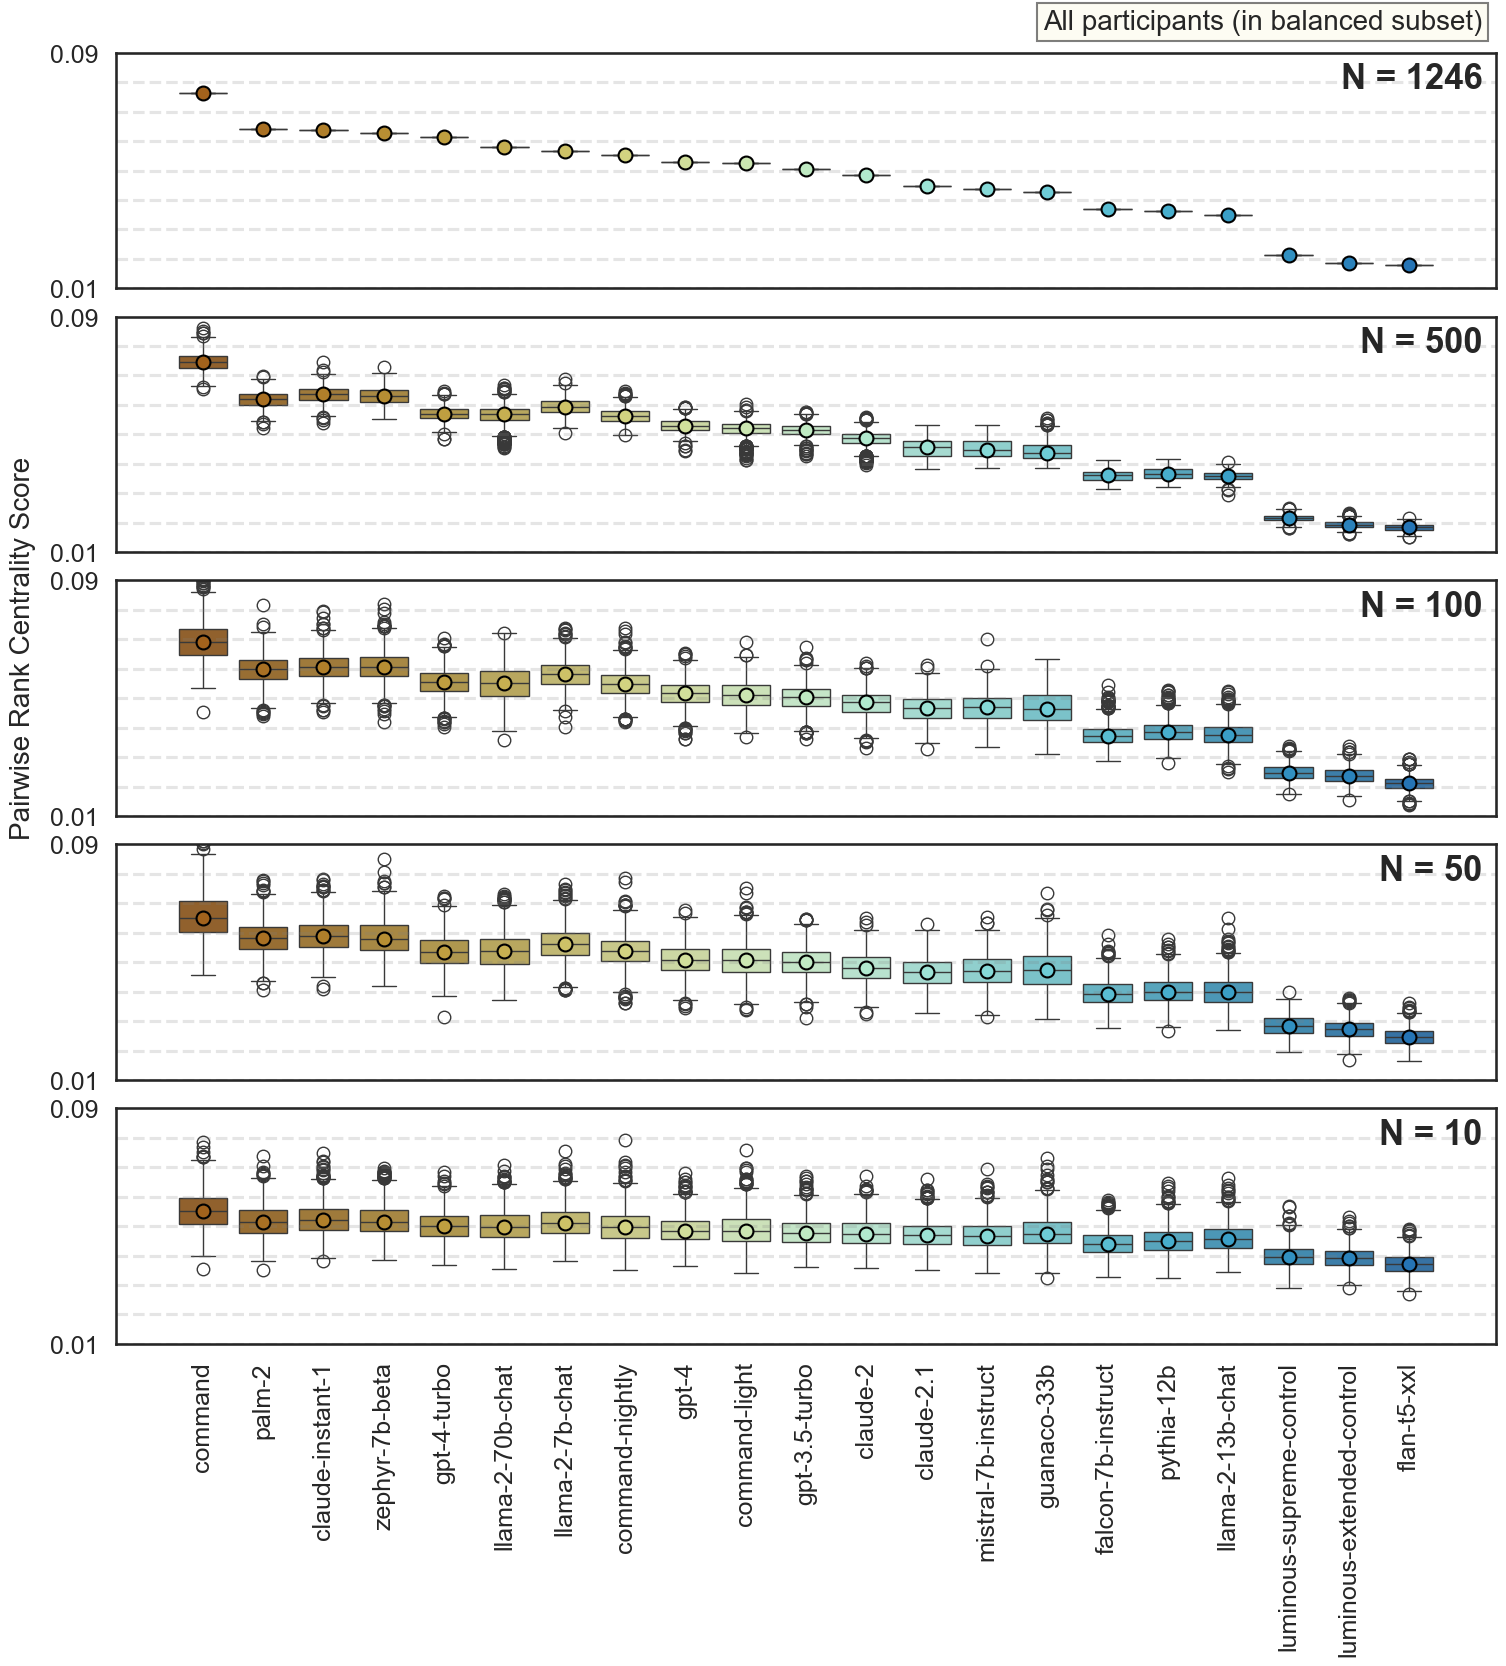

In [43]:
fig, ax = plt.subplots(5, 1, figsize=(15, 17), sharex=True)
for i, (sample_n, all_dfs) in enumerate(store.items()):
    score_df = all_dfs[0]
    score_df = score_df[order]
    # Box plot of pairwise rank centrality score distribution
    sns.boxplot(data=score_df, ax=ax[i], palette=color_mapping.values())
    if sample_n == "all":
        # Add an explanatory note
        ax[i].text(
            0.99,
            1.1,
            "All participants (in balanced subset)",
            ha="right",
            transform=ax[i].transAxes,
            fontsize=20,
            bbox=dict(facecolor=basic_colors_dict["oat"], alpha=0.5, edgecolor="black"),
        )
        # Put text in top right corner
        text = f"N = {len(VALID_USERS)}"

    else:
        text = f"N = {sample_n}"
    ax[i].text(
        0.99,
        0.85,
        text,
        ha="right",
        transform=ax[i].transAxes,
        fontsize=25,
        fontweight="semibold",
    )
    # Plot median as scatter
    medians = score_df.median()
    for j, median in enumerate(medians):
        ax[i].scatter(
            j,
            median,
            color=color_mapping[medians.index[j]],
            s=100,
            zorder=100,
            edgecolor="black",
        )

    # Common axis range to not distort comparisons
    ax_range = [0.01, 0.09]
    # Every 0.01 in range plot vline (easier on the eye!)
    for j in np.arange(ax_range[0], ax_range[1], 0.01):
        ax[i].axhline(j, color="grey", linestyle="--", alpha=0.2)
    ax[i].set_ylim(ax_range)
    ax[i].yaxis.set_major_locator(FixedLocator(ax_range))

# Rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# Add common xlabel
fig.text(
    0.0,
    0.5,
    "Pairwise Rank Centrality Score",
    ha="center",
    rotation=90,
    transform=fig.transFigure,
    fontsize=20,
)

# Reduce space between plots
plt.subplots_adjust(wspace=0.15, hspace=0.12)
# Save
plt.savefig(
    f"{PLOT_PATH}/idiosyncratic_rank_centrality.pdf",
    format="pdf",
    bbox_inches="tight",
)

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

#### Horizontal Panels

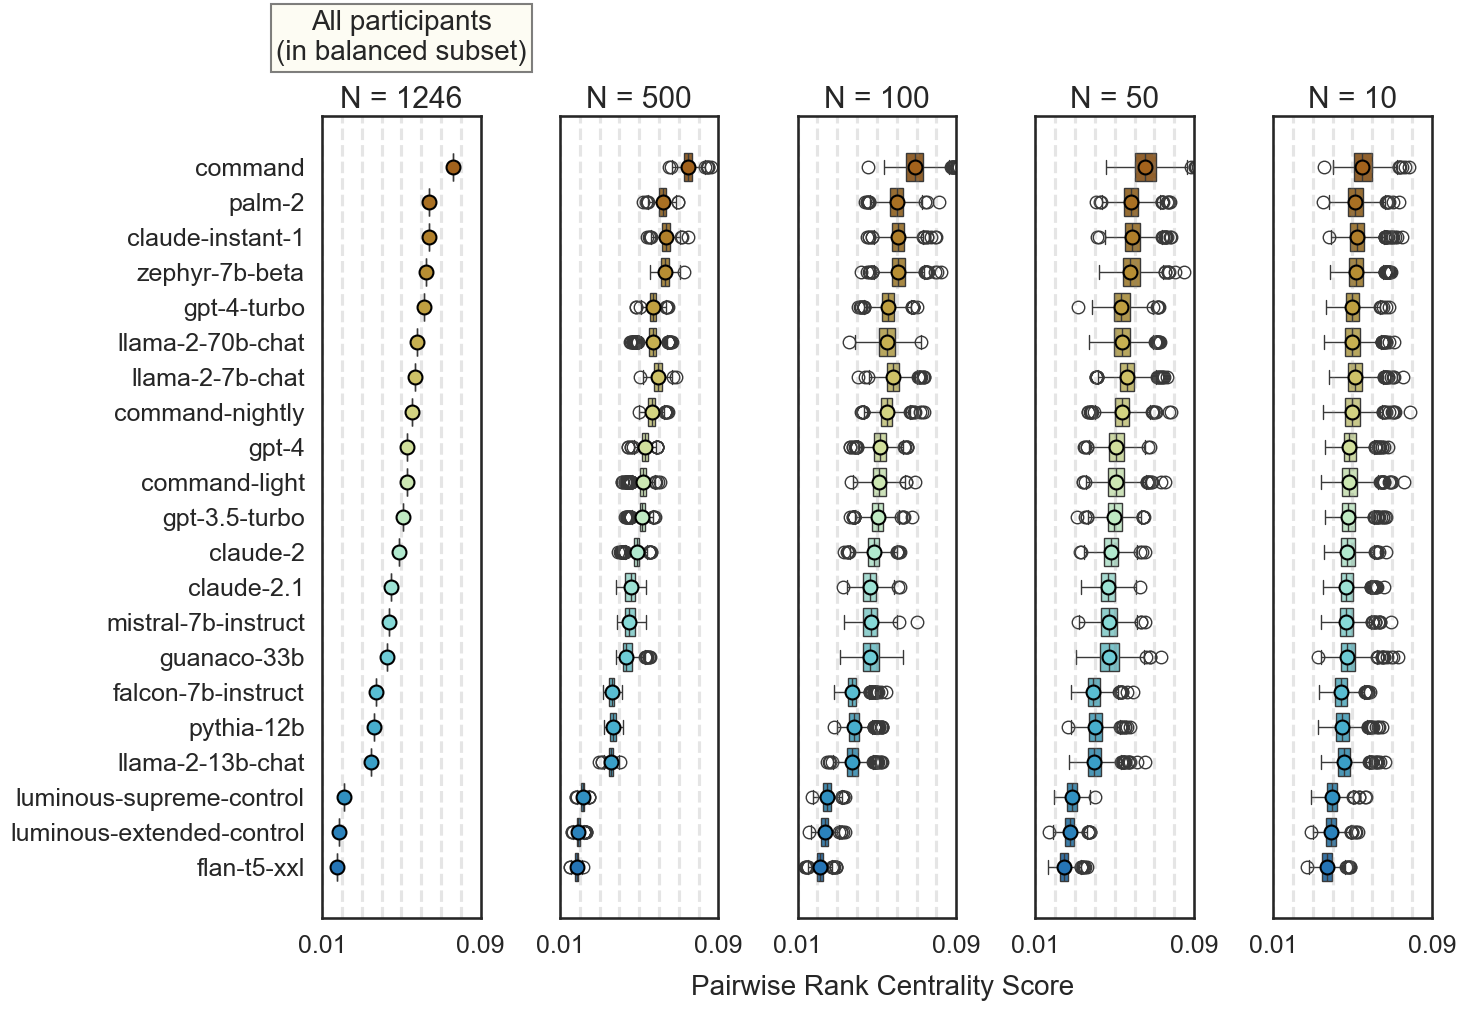

In [44]:
# Same as above but horizontal version (would be neater to combine)
fig, ax = plt.subplots(1, 5, figsize=(15, 10), sharey=True)
for i, (sample_n, all_dfs) in enumerate(store.items()):
    score_df = all_dfs[0]
    score_df = score_df[order]
    sns.boxplot(data=score_df, ax=ax[i], orient="h", palette=color_mapping.values())
    if sample_n == "all":
        ax[i].text(
            0.5,
            1.07,
            "All participants\n(in balanced subset)",
            ha="center",
            transform=ax[i].transAxes,
            fontsize=20,
            bbox=dict(facecolor=basic_colors_dict["oat"], alpha=0.5, edgecolor="black"),
        )
        ax[i].set_title(f"N = 1246")
    else:
        ax[i].set_title(f"N = {sample_n}")
    medians = score_df.median()
    for j, median in enumerate(medians):
        ax[i].scatter(
            median,
            j,
            color=color_mapping[medians.index[j]],
            s=100,
            zorder=100,
            edgecolor="black",
        )
    if i < 6:
        ax_range = [0.01, 0.09]
        for j in np.arange(ax_range[0], ax_range[1], 0.01):
            ax[i].axvline(j, color="grey", linestyle="--", alpha=0.2)
        ax[i].set_xlim(ax_range)
        ax[i].xaxis.set_major_locator(FixedLocator(ax_range))
plt.tight_layout()
fig.text(
    0.6,
    -0.01,
    "Pairwise Rank Centrality Score",
    ha="center",
    transform=fig.transFigure,
    fontsize=20,
)
plt.subplots_adjust(wspace=0.5)
# Save
plt.savefig(
    f"{PLOT_PATH}/idiosyncratic_rank_centrality_horizontal.pdf",
    format="pdf",
    bbox_inches="tight",
)
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

### Group Variation

In [45]:
# Variance in rank by which groups or data subsets we include
def get_group_ranks(
    openers,
    demo_col,
    tie_thresh=5,
    get_overall=False,
    do_bootstrap=False,
    BOOTSTRAP_ITER=1000,
):
    # Find the rank centrality score for each group (subset of data)
    scores = {}
    if get_overall:
        # Just get all the battles if "overall"
        overall = pd.DataFrame(extract_battles(openers, tie_thresh=tie_thresh))
        if do_bootstrap:
            overall_rc = get_bootstrap_result(
                overall, compute_rank_centrality, BOOTSTRAP_ITER, frac=1.0
            )
            # Not sure it makes sense to take a median of these scores if we're not showing the distribution
            scores["Overall"] = overall_rc.median()
        else:
            overall_rc = compute_rank_centrality(overall)
            scores["Overall"] = overall_rc
    # Loop through the categories in this group (e.g., male, female, non-binary, .., in gender)
    for attr in openers[demo_col].unique():
        print(f"## {attr} ##")
        # Get their specific battles
        battles = pd.DataFrame(
            extract_battles(openers[openers[demo_col] == attr], tie_thresh=tie_thresh)
        )
        n_battles = len(battles)
        print(f"Number of battles: {n_battles}")
        n_users = openers["user_id"][openers[demo_col] == attr].nunique()
        # Don't include this group if there aren't at least 20 unique people in it
        if n_users < 20:
            print(f"Skipping {attr}, insufficient users ({n_users})")
            continue
        print(f"Unique users: {n_users}")
        # Also don't include people who say "Prefer not to say"
        if attr == "Prefer not to say":
            continue
        if do_bootstrap:
            rc_scores = get_bootstrap_result(
                battles, compute_rank_centrality, BOOTSTRAP_ITER, frac=1.0
            )
            # Get median
            median_rc = rc_scores.median()
            scores[attr] = median_rc
        else:
            rc = compute_rank_centrality(battles)
            scores[attr] = rc

    score_df = pd.DataFrame(scores)
    rank_df = score2rank(
        score_df, multimetric=False, metric_name="rank_centrality_score"
    )

    return score_df, rank_df

## Female ##
Number of battles: 16964
Unique users: 606
## Male ##
Number of battles: 17780
Unique users: 621
## Non-binary / third gender ##
Number of battles: 576
Skipping Non-binary / third gender, insufficient users (19)


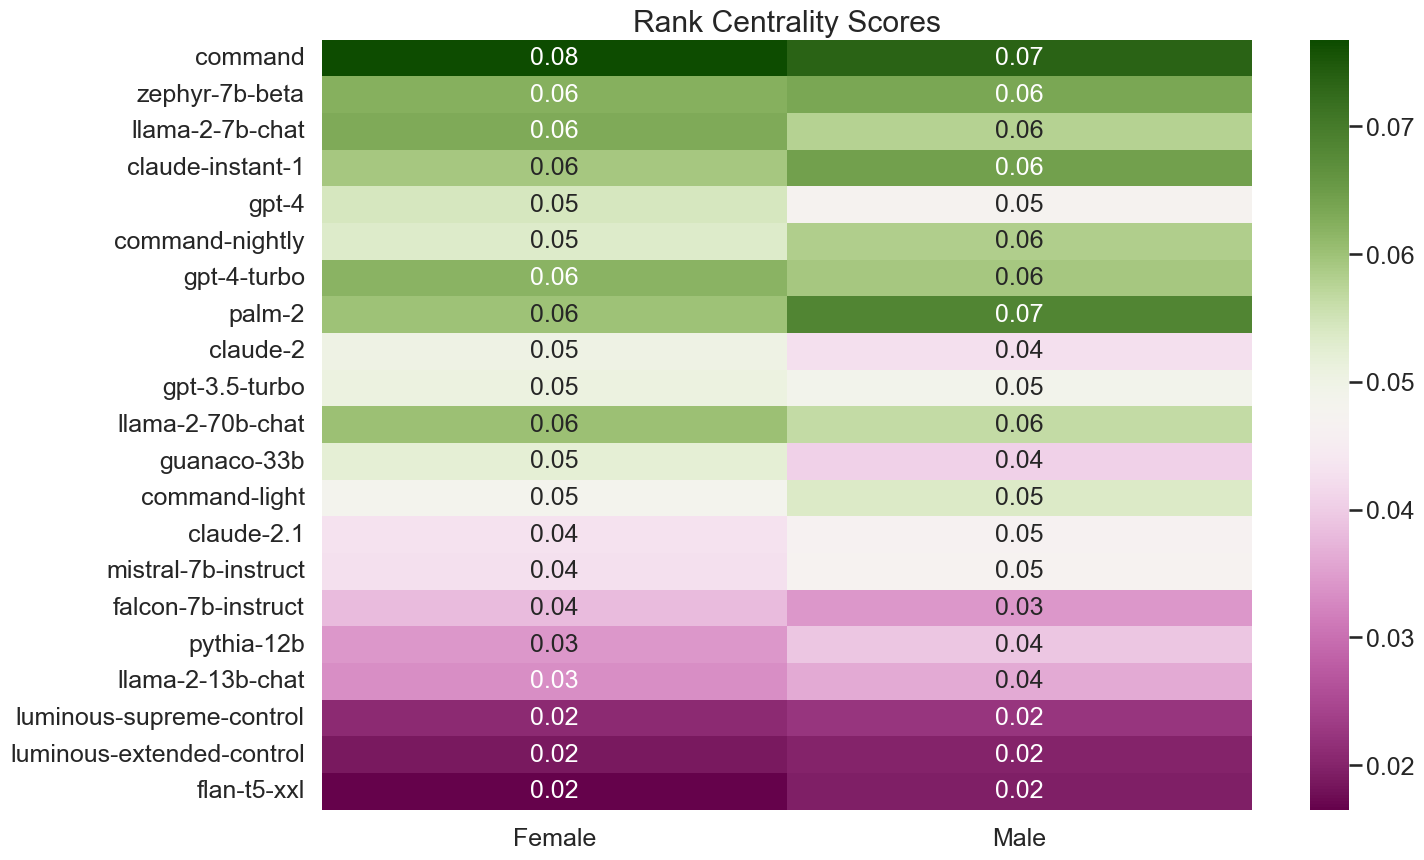

In [46]:
# Example usage
score_df, rank_df = get_group_ranks(
    VALID_OPENERS,
    "gender",
    tie_thresh=5,
    BOOTSTRAP_ITER=BOOTSTRAP_ITER,
    get_overall=False,
    do_bootstrap=False,
)

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(score_df, annot=True, cmap=palettes_dict["bam"], fmt=".2f")
plt.title("Rank Centrality Scores")
plt.show()

### Combining Sources of Variation

In [47]:
## RUN IDIOSYNCRATIC VAR
sample_n = 100
idio_score_df, idio_rank_df = store[sample_n][0], store[sample_n][1]

In [48]:
## RUN DEMOGRAPHIC VAR
demo_score_df, demo_rank_df = get_group_ranks(
    VALID_OPENERS,
    "location_special_region",
    get_overall=True,
    do_bootstrap=False,
)
# Drop N.America and Middle East (these have very low country diversity)
demo_rank_df = demo_rank_df.drop(["Northern America", "Middle East"], axis=1)

# Get order
order = survey["location_special_region"].value_counts().index
order = [c for c in order if c in demo_rank_df.columns and c != "Overall"]
demo_rank_df = demo_rank_df[["Overall"] + order]

## Europe ##
Number of battles: 7738
Unique users: 264
## Africa ##
Number of battles: 2910
Unique users: 105
## US ##
Number of battles: 7019
Unique users: 258
## Asia ##
Number of battles: 1286
Unique users: 49
## Latin America and the Caribbean ##
Number of battles: 3748
Unique users: 131
## Australia and New Zealand ##
Number of battles: 3222
Unique users: 111
## Northern America ##
Number of battles: 1213
Unique users: 42
## UK ##
Number of battles: 7081
Unique users: 245
## Middle East ##
Number of battles: 1037
Unique users: 37
## Oceania ##
Number of battles: 18
Skipping Oceania, insufficient users (1)
## Prefer not to say ##
Number of battles: 48
Skipping Prefer not to say, insufficient users (3)


In [49]:
## RUN CONVERSATIONAL CONTEXT VAR
convo_score_df, convo_rank_df = get_group_ranks(
    VALID_OPENERS,
    "conversation_type",
    get_overall=True,
    BOOTSTRAP_ITER=BOOTSTRAP_ITER,
    do_bootstrap=False,
)

## values guided ##
Number of battles: 11781
Unique users: 1246
## unguided ##
Number of battles: 11878
Unique users: 1246
## controversy guided ##
Number of battles: 11661
Unique users: 1246


In [50]:
# Note we do have equal number of conversations in this balanced subset
# but there is still some (assumed random) variability in battles if e.g., a model failed
print(VALID_OPENERS["conversation_type"].value_counts())

conversation_type
values guided         2232
unguided              2232
controversy guided    2232
Name: count, dtype: int64


In [51]:
# Sort columns in order
order = ["Overall", "unguided", "values guided", "controversy guided"]
convo_rank_df = convo_rank_df[order]

In [52]:
## SYCHRONISE
demo_rank_df.sort_index(inplace=True)
convo_rank_df.sort_index(inplace=True)
location_overall_rank = demo_rank_df["Overall"]
convo_overall_rank = convo_rank_df["Overall"]

# Combine into dataframe (to check alignment)
overall_df = pd.concat([convo_overall_rank, location_overall_rank], axis=1)

display(overall_df)

Overall  Overall
claude-2                      12.0     12.0
claude-2.1                    13.0     13.0
claude-instant-1               3.0      3.0
command                        1.0      1.0
command-light                 10.0     10.0
command-nightly                8.0      8.0
falcon-7b-instruct            16.0     16.0
flan-t5-xxl                   21.0     21.0
gpt-3.5-turbo                 11.0     11.0
gpt-4                          9.0      9.0
gpt-4-turbo                    5.0      5.0
guanaco-33b                   15.0     15.0
llama-2-13b-chat              18.0     18.0
llama-2-70b-chat               6.0      6.0
llama-2-7b-chat                7.0      7.0
luminous-extended-control     20.0     20.0
luminous-supreme-control      19.0     19.0
mistral-7b-instruct           14.0     14.0
palm-2                         2.0      2.0
pythia-12b                    17.0     17.0
zephyr-7b-beta                 4.0      4.0

In [53]:
# We need a common model order for the plot
model_order = convo_rank_df["Overall"].sort_values().index
print(model_order)

Index(['command', 'palm-2', 'claude-instant-1', 'zephyr-7b-beta',
       'gpt-4-turbo', 'llama-2-70b-chat', 'llama-2-7b-chat', 'command-nightly',
       'gpt-4', 'command-light', 'gpt-3.5-turbo', 'claude-2', 'claude-2.1',
       'mistral-7b-instruct', 'guanaco-33b', 'falcon-7b-instruct',
       'pythia-12b', 'llama-2-13b-chat', 'luminous-supreme-control',
       'luminous-extended-control', 'flan-t5-xxl'],
      dtype='object')


In [54]:
# TBD whether this actually adds readability
def is_dark_color(color):
    # Convert the color to RGB
    r, g, b = color[:3]
    # Calculate the luminance using a formula
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    # Return True if the color is dark, False otherwise
    return luminance < 0.5

In [55]:
# Little function to a label inside a black circle at the specified position of the axis
# Labels the panels for clarity, e.g., "A", "B", "C"
def add_label(ax, label, xpos="right", ypos="top", color="black", text_color="white"):
    bbox_props = dict(boxstyle="circle", fc=color, ec=color, lw=1)
    ha = {"right": "left", "left": "right"}.get(xpos, "right")
    va = {"top": "bottom", "bottom": "top"}.get(ypos, "top")
    ax.text(
        0.95,
        0.98,
        label,
        transform=ax.transAxes,
        color=text_color,
        ha=ha,
        va=va,
        fontsize=40,
        fontweight="bold",
        bbox=bbox_props,
    )

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_5712/277020400.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_yticklabels([f"{label}" for label in model_order], fontsize=model_size)


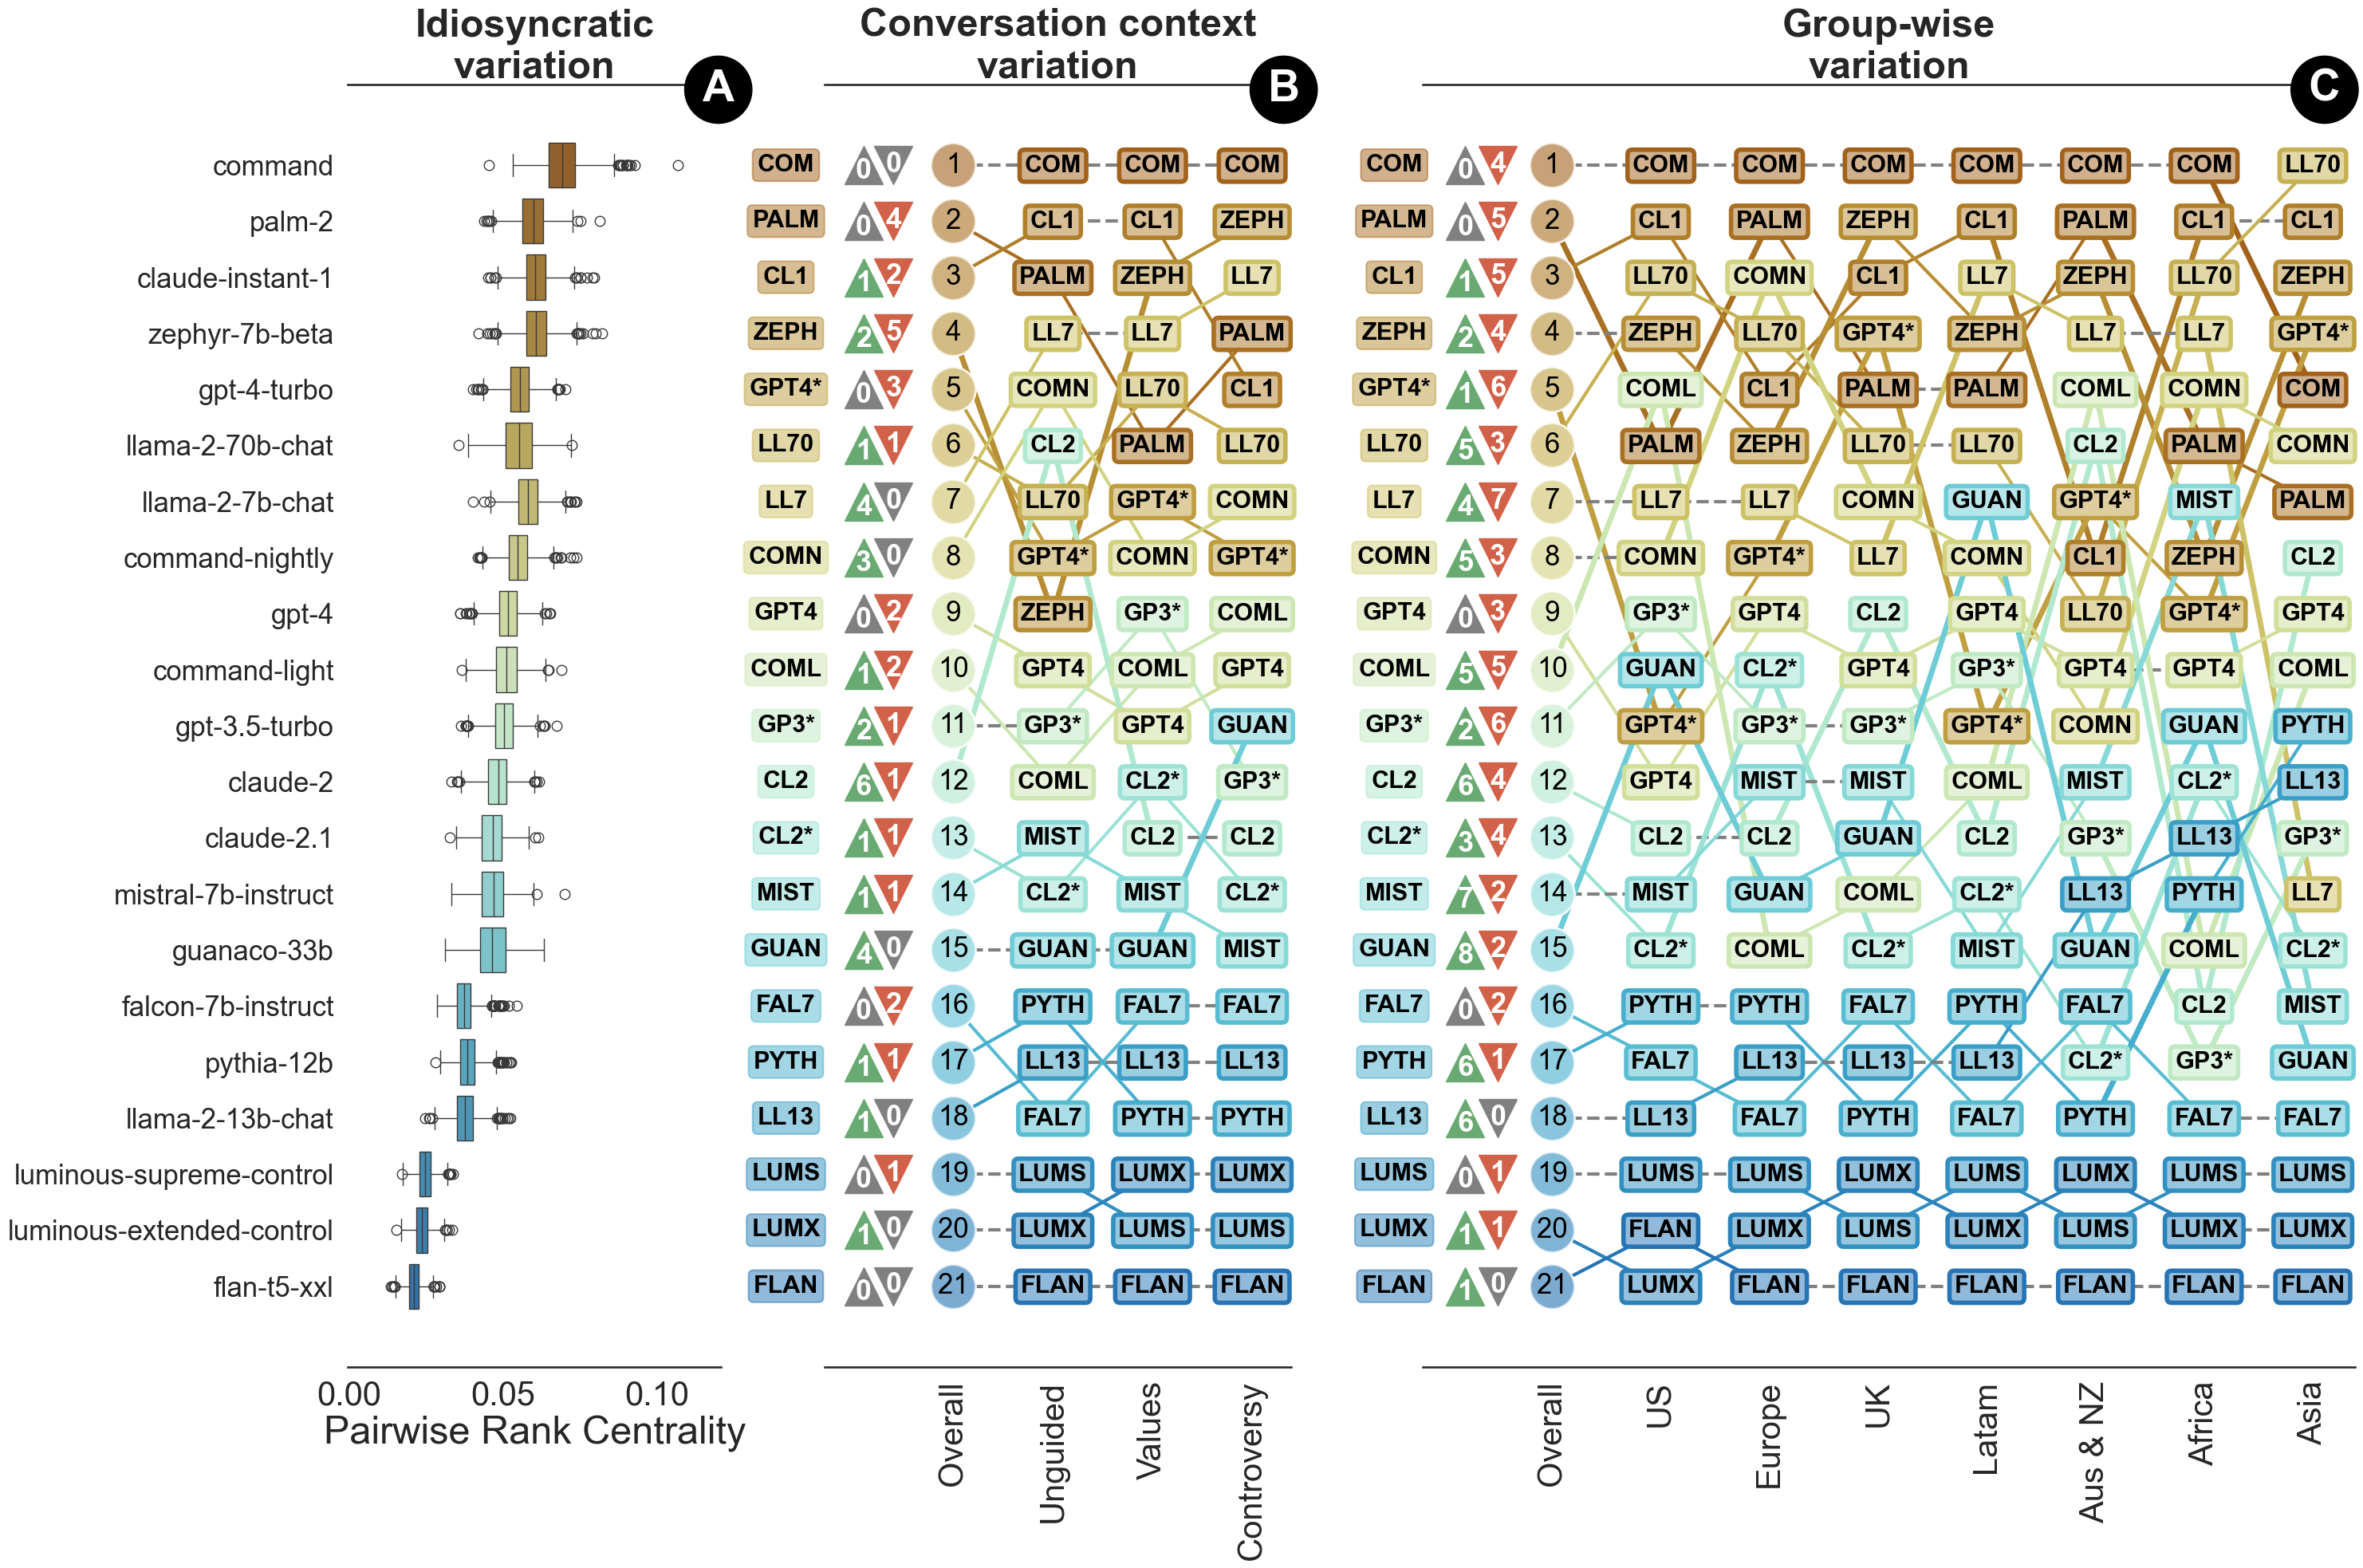

In [56]:
##########################################################
# PUTTING IT ALL TOGETHER!
##########################################################

# Adjusting the figure layout to have subplots with different widths
fig = plt.figure(figsize=(30, 20))
gs = gridspec.GridSpec(1, 5, width_ratios=[4, 0.7, 5, 1, 10])

# Now create the subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(
    gs[2],
    sharey=ax0,
)  # Share y-axis with the first subplot
ax2 = plt.subplot(gs[4], sharey=ax0)
axa = plt.subplot(gs[1], sharey=ax0)  # These ones are just spacer axis
axb = plt.subplot(gs[3], sharey=ax0)  # These ones are just spacer axis

# Adding black circles with labels to main panels
add_label(ax0, "A")
add_label(ax1, "B")
add_label(ax2, "C")

# Combine
ax = [ax0, axa, ax1, axb, ax2]


# FONTSIZES (Can tweak these across all panels)
tick_size = 30
axis_label_size = 35
model_size = 25
title_size = 35
model_code_size = 22
group_size = 30

##########################################################
# VIOLIN = FIRST PANEL
##########################################################
idio_score_df = idio_score_df[model_order]
colors = get_equally_spaced_colors(palettes_dict["roma"], 21)
sns.boxplot(data=idio_score_df, palette=colors, orient="h", ax=ax0)

# Add model code from score_df
for label_ax, name in zip([axa, axb], ["a", "b"]):
    ax = label_ax
    if name == "a":
        gap = 0.7
    else:
        gap = 0.9
    for i, model in enumerate(model_order):
        text_color = "white" if is_dark_color(colors[i]) else "black"
        ax.text(
            gap,
            i,
            model_code_mapping[model],
            ha="center",
            va="center",
            fontsize=model_code_size,
            zorder=101,
            color="black",
            fontweight="semibold",
            bbox=dict(
                facecolor=colors[i],
                alpha=0.5,
                edgecolor=colors[i],
                boxstyle="round,pad=0.2",
            ),
        )

# Increase y tick size
ax0.tick_params(axis="both", which="major", labelsize=tick_size)
ax0.set_xlabel("Pairwise Rank Centrality", fontsize=axis_label_size)

# Get y positions
y_tick_positions = ax0.get_yticks()

# Y-axis labels are the model names so we pair with corresponding positions
model_names = [tick_label.get_text() for tick_label in ax0.get_yticklabels()]
model_positions = dict(zip(model_names, y_tick_positions))
model2color = {model: color for model, color in zip(model_names, colors)}

# Now add some padding
ax0.set_yticklabels([f"{label}" for label in model_order], fontsize=model_size)
ax0.margins(x=0.15)


##########################################################
# PARALLEL RANK PLOTS = SECOND AND THIRD PANELS
##########################################################
# Maybe want to store the changes in gradient e.g., to color or adjust the lines based on movement.
GRADS = []
label_markers = True
for rank_df, name in zip(
    [
        convo_rank_df,
        demo_rank_df,
    ],
    ["conversation_type", "location_special_region"],
):
    if name == "conversation_type":
        ax = ax1
    else:
        ax = ax2
    columns = rank_df.columns
    # Loop through model positions
    for model, position in model_positions.items():
        # Draw a line at the model position
        row = rank_df.loc[model]
        y = row[[col for col in columns]].values - 1
        x = np.arange(len(columns))
        # Save the gradients
        gradients = np.diff(y) / np.diff(x)
        grad_colormap = get_equally_spaced_colors(plt.cm.bwr_r, 20)
        color_dict = {}
        # Put some limit on the grad color mapping
        for i in np.arange(start=-10, stop=11, step=1):
            color_dict[i] = grad_colormap[i]

        # Plot each line segment individually
        for seg in range(len(x) - 1):
            segment_x = [x[seg], x[seg + 1]]
            segment_y = [y[seg], y[seg + 1]]
            grad = gradients[seg]
            # Color grey if no movement (easier on the eye!)
            if np.abs(grad) == 0:
                alpha = 1
                linewidth = 3
                color = "grey"
                linestyle = "--"
            else:
                # color =color_dict[grad]  #TBC, this is visually complex to color by movement
                color = model2color[model]
                linestyle = "-"
                if np.abs(grad) > 3:
                    alpha = 1
                    linewidth = 5
                elif 0 < np.abs(grad) < 1:
                    alpha = 1
                    linewidth = 3
                else:
                    alpha = 1
                    linewidth = 3
            # color = grad_colormap(normalized_gradients[seg])  # Get color based on normalized gradient (too complex)
            ax.plot(
                segment_x,
                segment_y,
                color=color,
                linewidth=linewidth,
                linestyle=linestyle,
                alpha=alpha,
            )

        # Add movement triangles
        starting_y = y[0]
        max_y = np.max(y)
        min_y = np.min(y)
        spots_fallen = y[0] - max_y
        spots_climbed = y[0] - min_y
        if name == "conversation_type":
            triangle_climb = np.min(x) - 0.9
            triangle_fall = np.min(x) - 0.6
        else:
            triangle_climb = np.min(x) - 0.8
            triangle_fall = np.min(x) - 0.5

        # Greyscale if no movement
        if spots_climbed == 0:
            color = "grey"
        else:
            color = "#69aa72"

        # Draw spots climbed
        ax.plot(triangle_climb, y[0], "^", color=color, markersize=35)
        ax.text(
            triangle_climb,
            y[0] - 0.125,
            f"{int(spots_climbed)}",
            color="white",
            va="top",
            ha="center",
            fontsize=26,
            fontweight="bold",
        )

        # Greyscale if no movement
        if spots_fallen == 0:
            color = "grey"
        else:
            color = "#d16249"

        # Draw spots climbed
        ax.plot(triangle_fall, y[0], "v", color=color, markersize=35)
        ax.text(
            triangle_fall,
            y[0] + 0.225,
            f"{np.abs(int(spots_fallen))}",
            color="white",
            va="bottom",
            ha="center",
            fontsize=26,
            fontweight="bold",
        )

        # Loop through xs and ys (apart from first pos)
        for xi, yi in zip(x[1:], y[1:]):
            # Add model code
            text_color = "white" if is_dark_color(model2color[model]) else "black"
            # Dummy white box for reduced alpha
            ax.text(
                xi,
                yi + 0.01,
                f"{model_code_mapping[model]}",
                ha="center",
                va="center",
                fontsize=model_code_size,
                zorder=101,
                color="white",
                fontweight="semibold",
                # Fancy box
                bbox=dict(
                    facecolor="white",
                    alpha=1,
                    linewidth=4,
                    edgecolor=model2color[model],
                    boxstyle="round,pad=0.2",
                ),
            )
            # Actual code
            ax.text(
                xi,
                yi + 0.01,
                f"{model_code_mapping[model]}",
                ha="center",
                va="center",
                fontsize=model_code_size,
                zorder=101,
                color="black",  # text_color,
                fontweight="semibold",
                # Fancy box
                bbox=dict(
                    facecolor=model2color[model],
                    alpha=0.5,
                    edgecolor=model2color[model],
                    linewidth=0,
                    boxstyle="round,pad=0.2",
                ),
            )

        #### CIRCLE MARKERS ####
        if name == "conversation_type" or name == "location_special_region":
            #  Dummy circle (for reduced alpha)
            ax.plot(
                0,
                y[0],
                "o",
                ms=40,
                color=model2color[model],
                markeredgecolor="white",
                markeredgewidth=2,
                zorder=100,
                alpha=0.6,
            )

            ax.plot(
                0,
                y[0],
                "o",
                ms=40,
                color="white",
                markeredgecolor="white",
                markeredgewidth=2,
                zorder=99,
                alpha=1,
            )

            # Add the marker text for the model rank
            ax.text(
                0,
                y[0],
                model_positions[model] + 1,
                ha="center",
                va="center",
                fontsize=25,
                color="black",
                zorder=101,
            )

    # Clean labels for x-axis
    clean_labels = [
        demo2label[name][label] if label != "Overall" else "Overall"
        for label in columns
    ]
    ax.set_xticks(
        ticks=np.arange(len(columns)),
        labels=clean_labels,
        rotation=90,
        fontsize=group_size,
    )

# Add some margins
ax1.margins(x=0.1)

#### TITLES ####
ax0.set_title("Idiosyncratic\nvariation", fontweight="bold", fontsize=title_size)
ax1.set_title("Conversation context\nvariation", fontweight="bold", fontsize=title_size)
ax2.set_title("Group-wise\nvariation", fontweight="bold", fontsize=title_size)

# Turn off axis border for clean look
for ax in [axa, axb, ax1, ax2]:
    for label in ax.get_yticklabels():
        label.set_visible(False)

# Adjust white space
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)

# Turn off axis border
for a in [ax0, ax1, ax2, axa, axb]:
    a.spines["right"].set_visible(False)
    a.spines["left"].set_visible(False)

for a in [axa, axb]:
    a.axis("off")


# Save
plt.savefig(
    f"{PLOT_PATH}/rank_centrality_combined_double.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()